# Signate開始時のお約束

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [4]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=2d4879279b1ee08a1a1319198acbb7610f32e3e1d961574f8dd01dbe57a8c651
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [5]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [6]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [7]:
!pip install kanjize

In [8]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.7 MB/s eta 0:00:00


In [9]:
!pip install shap

In [10]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [108]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [109]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]
    # 数値変換し5足す
    tmp = int(tmp)
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

<ipython-input-109-766871c38253>:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

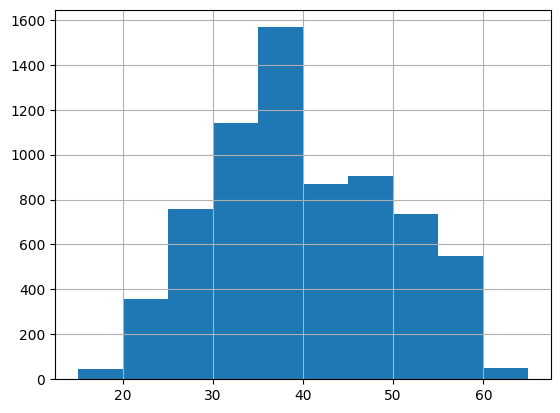

In [110]:
all_df["Age"].hist()

In [111]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損を埋める
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

In [112]:
# 分類の確認
all_df["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,4462
Company Invited,2516


In [113]:
#########################
# "CityTier"の処理 #
#########################
# 分類の確認
all_df["CityTier"].value_counts()
# all_df["CityTier"].isnull().sum()

,count
CityTier,
2,3160
1,2991
3,827


In [114]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

<Axes: >

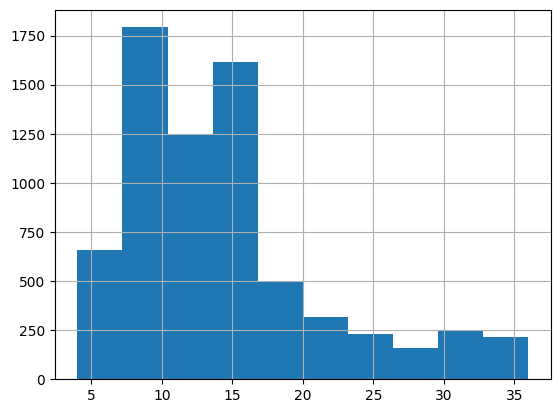

In [115]:
# 分布の確認
all_df["DurationOfPitch"].hist()

In [116]:
####################
# "Occupation"の処理 #
####################
# 個人事業主/会社員/大企業の3択のためホットエンコードにする
all_df["Occupation"].value_counts()
# all_df["Occupation"].isnull().sum()

,count
Occupation,
Small Business,3456
Salaried,2801
Large Business,721


In [117]:
##################
# "Genger"の処理 #
##################
# all_df["Gender"].isnull().sum()
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])

  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"

  else:
    all_df.loc[i,"Gender"] = "Female"

In [118]:
# 分類の確認
all_df["Gender"].value_counts()

,count
Gender,
Female,5946
Male,1032


In [119]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
all_df["NumberOfPersonVisiting"].value_counts()
# all_df["NumberOfPersonVisiting"].isnull().sum()

,count
NumberOfPersonVisiting,
2.0,3163
3.0,2773
1.0,686
4.0,356


In [120]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# all_df["NumberOfFollowups"].value_counts()
# all_df["NumberOfFollowups"].isnull().sum()
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

In [121]:
# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

In [122]:
# 分布の確認
all_df["NumberOfFollowups"].value_counts()

,count
NumberOfFollowups,
4.0,2834
3.0,2561
5.0,1122
2.0,213
1.0,178
6.0,70


In [123]:
##########################
# "ProductPitched"の処理 #
##########################
# ind_name = all_df["ProductPitched"].value_counts().index.values
# all_df["ProductPitched"].isnull().sum()

In [124]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [125]:
# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

In [126]:
# 分布の確認
all_df["ProductPitched"].value_counts()

,count
ProductPitched,
Basic,2347
Deluxe,2091
Standard,1614
SuperDeluxe,640
King,286


In [127]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# all_df["PreferredPropertyStar"].isnull().sum()

# 2引いて揃える
# all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


In [128]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

<Axes: >

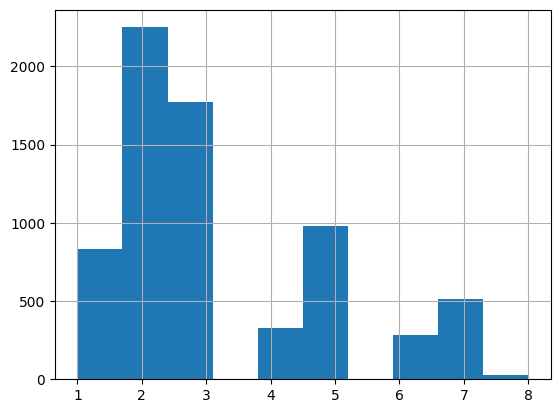

In [129]:
# ヒストグラムの確認
all_df["NumberOfTrips"].hist()

In [130]:
#########################
# "Passport"の処理 #
#########################
# all_df["Passport"].isnull().sum()
all_df["Passport"].value_counts()

,count
Passport,
0,6288
1,690


<Axes: >

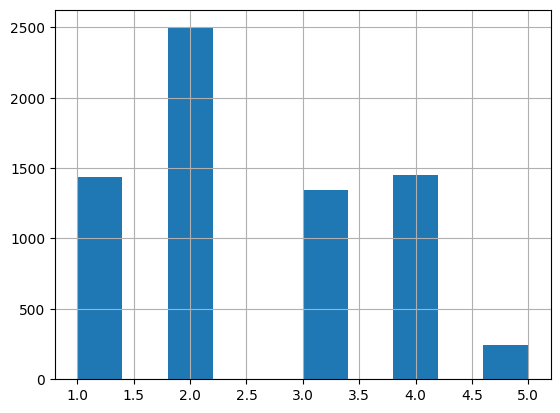

In [131]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
# all_df["PitchSatisfactionScore"].isnull().sum()
# all_df["PitchSatisfactionScore"].value_counts()
all_df["PitchSatisfactionScore"].hist()

In [132]:
#########################
# "Designation"の処理 #
#########################
# all_df["Designation"].isnull().sum()
# all_df["Designation"].value_counts()

In [133]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [134]:
# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

In [135]:
# 分類の確認
all_df["Designation"].value_counts()

,count
Designation,
Executive,2330
Manager,2117
Senior Manager,1632
AVP,635
VP,264


In [136]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

<Axes: >

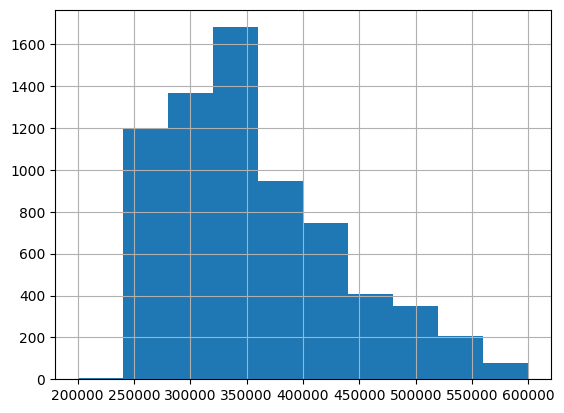

In [137]:
# 分布の確認
all_df["MonthlyIncome"].hist()

In [138]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [139]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [140]:
# 車保有率
all_df["CarHolder"].value_counts()

,count
CarHolder,
0,4408
1,2570


In [141]:
# 子供の数
all_df["NumofChild"].value_counts()

,count
NumofChild,
0,5015
1,1347
2,571
3,45


In [142]:
# 婚姻歴
all_df["Married"].value_counts()

,count
Married,
Married,2846
Single,2444
Divorce,1688


# 特徴量エンジニアリング

In [143]:
# 「Dsignation」をラベルエンコード
all_df["Designation_LE"] = 1
all_df.loc[all_df["Designation"]=="Executive","Designation_LE"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation_LE"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation_LE"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation_LE"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation_LE"] = 1

# 「Occupation」をラベルエンコード
all_df["Occupation_LE"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","Occupation_LE"] = 3
all_df.loc[all_df["Occupation"]=="Small Business","Occupation_LE"] = 2
all_df.loc[all_df["Occupation"]=="Salaried","Occupation_LE"] = 1

# 「CarHolder」をラベルエンコード
all_df["CarHolder_LE"] = all_df["CarHolder"] + 1

# 「Gender」をラベルエンコード
all_df["Gender_LE"] = 1
all_df.loc[all_df["Gender"]=="Female","Gender_LE"]=2
all_df.loc[all_df["Gender"]=="Male","Gender_LE"]=2

# 「ProductPitched」をラベルエンコード
all_df["ProductPitched_LE"] = 1
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched_LE"]=5
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched_LE"]=4
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched_LE"]=3
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched_LE"]=2
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched_LE"]=1

# 「Married」をラベルエンコード
all_df["Married_LE"] = 1
all_df.loc[all_df["Married"]=="Married","Married_LE"]=3
all_df.loc[all_df["Married"]=="Divorce","Married_LE"]=2
all_df.loc[all_df["Married"]=="Single","Married_LE"]=1

# 「TypeofContact」をラベルエンコード
all_df["TypeofContact_LE"] = 1
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact_LE"]=2
all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact_LE"]=1

In [144]:
# エンコード前のラベルを抹消する
all_df = all_df.drop("Designation", axis=1)
all_df = all_df.drop("Occupation", axis=1)
all_df = all_df.drop("Gender", axis=1)
all_df = all_df.drop("ProductPitched", axis=1)
all_df = all_df.drop("Married", axis=1)
all_df = all_df.drop("CarHolder", axis=1)
all_df = all_df.drop("TypeofContact", axis=1)

In [145]:
# --------------------
# クロス特徴量を加える
# --------------------
# 役職と月収
all_df["Designation_MonthlyIncome"] = all_df["Designation_LE"] * all_df["MonthlyIncome"]
# 役職と商品ランク
all_df["Designation_ProductPitched"] = all_df["Designation_LE"] * all_df["ProductPitched_LE"]
# 役職と年齢
all_df["Designation_Age"] = all_df["Designation_LE"] * all_df["Age"]
# 役職と職業
all_df["Designation_Occupation"] = all_df["Designation_LE"] * all_df["Occupation_LE"]
# 月収と商品ランク
all_df["MonthlyIncome_ProductPitched"] = all_df["MonthlyIncome"] * all_df["ProductPitched_LE"]
# 月収と年齢
all_df["MonthlyIncome_Age"] = all_df["MonthlyIncome"] * all_df["Age"]
# 月収と婚姻歴
all_df["MonthlyIncome_Married"] = all_df["MonthlyIncome"] * all_df["Married_LE"]
# 月収と都市富裕度
all_df["MonthlyIncome_CityTier"] = all_df["MonthlyIncome"] * all_df["CityTier"]
# 月収と職業
all_df["MonthlyIncome_Occupation"] = all_df["MonthlyIncome"] * all_df["Occupation_LE"]
# 月収と車
all_df["MonlyIncome_CarHolder"] = all_df["MonthlyIncome"] * all_df["CarHolder_LE"]
# 月収と子供の数
all_df["MonthlyIncome_NumofChild"] = all_df["MonthlyIncome"] * all_df["NumofChild"]
# 商品ランクと年齢
all_df["ProductPitched_Age"] = all_df["ProductPitched_LE"] * all_df["Age"]

In [146]:
# 新たな特徴量
# 標準化月収(月収/都市富裕度)
all_df["IncomeStandard"] = all_df["MonthlyIncome"] / all_df["CityTier"]
# 生活余裕度(月収/(子供の数+1))
all_df["IncomebyChild"] = all_df["MonthlyIncome"] / (all_df["NumofChild"] + 1)
# 顧客価値スコア(顧客満足度x年間旅行数)
all_df["SatisfactionNumOfTrips"] = all_df["PitchSatisfactionScore"] * all_df["NumberOfTrips"]
# 月収の妥当度
all_df["IncomebyAge"] = all_df["MonthlyIncome"] / all_df["Age"]

In [147]:
# 寄与度の高いもの以外は抹消する
all_df = all_df.drop("ProductPitched_LE", axis=1)
all_df = all_df.drop("NumberOfTrips", axis=1)
all_df = all_df.drop("DurationOfPitch", axis=1)
all_df = all_df.drop("Married_LE", axis=1)
all_df = all_df.drop("SatisfactionNumOfTrips", axis=1)
all_df = all_df.drop("CityTier", axis=1)

In [156]:
all_df = all_df.drop("NumberOfPersonVisiting", axis=1)
all_df = all_df.drop("MonthlyIncome_NumofChild", axis=1)
all_df = all_df.drop("PreferredPropertyStar", axis=1)
all_df = all_df.drop("Designation_ProductPitched", axis=1)
all_df = all_df.drop("NumberOfFollowups", axis=1)
all_df = all_df.drop("Occupation_LE", axis=1)
all_df = all_df.drop("CarHolder_LE", axis=1)
all_df = all_df.drop("NumofChild", axis=1)

In [ ]:
all_df = all_df.drop("Designation_Occupation", axis=1)
all_df = all_df.drop("TypeofContact_LE", axis=1)
all_df = all_df.drop("PitchSatisfactionScore", axis=1)
all_df = all_df.drop("IncomebyChild", axis=1)

In [ ]:
# 分布に偏りが見られそうなため、一つずつ確認していく

In [ ]:
train = all_df.loc[0:len(train_df)-1]

<Axes: >

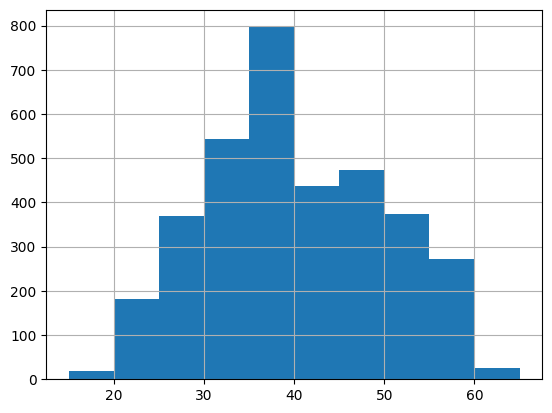

In [ ]:
train["Age"].hist()

In [ ]:
print(train.loc[train["Age"]<20,"ProdTaken"].mean())
print(train.loc[(train["Age"]>=20) & (train["Age"]<30),"ProdTaken"].mean())
print(train.loc[(train["Age"]>=30) & (train["Age"]<40),"ProdTaken"].mean())
print(train.loc[(train["Age"]>=40) & (train["Age"]<50),"ProdTaken"].mean())
print(train.loc[train["Age"]>=50,"ProdTaken"].mean())

0.5
0.30127041742286753
0.13965646004480955
0.08232711306256861
0.08955223880597014


In [ ]:
train.loc[train["Age"]>60,"Age"]

,Age
178,65
591,65
1154,61
1215,61
2335,61
2498,61
2529,65
2646,65
3276,61


<Axes: >

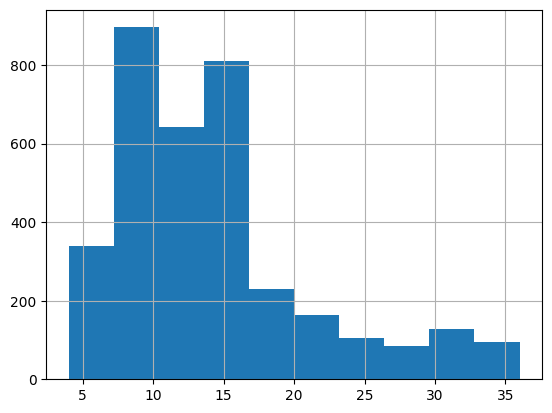

In [ ]:
# DurationOfPitch [分]
train["DurationOfPitch"].hist()

In [ ]:
# かけた時間と成功率に差はあるのか？
# 20分以上、10分以上、その他
# 対数変換する？
print(train.loc[train["DurationOfPitch"]>=15,"ProdTaken"].mean())
# print(train.loc[(train["DurationOfPitch"]>=10) & (train["DurationOfPitch"]<20),"ProdTaken"].mean())
# print(train.loc[train["DurationOfPitch"]<10,"ProdTaken"].mean())

0.14933135215453194


<Axes: >

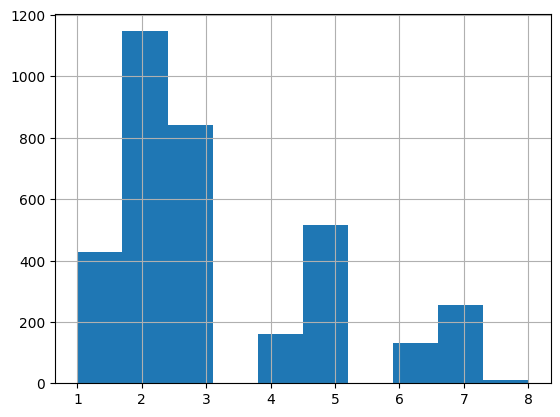

In [ ]:
# NumberOfTrips
train["NumberOfTrips"].hist()

In [ ]:
# 初回か6回以上の成功率が高い
print(train.loc[train["NumberOfTrips"]>=5,"ProdTaken"].mean())

# print(train.loc[train["NumberOfTrips"]>=6,"ProdTaken"].mean())
# print(train.loc[(train["NumberOfTrips"]>=3) & (train["NumberOfTrips"]<6),"ProdTaken"].mean())
# print(train.loc[train["NumberOfTrips"]<3,"ProdTaken"].mean())

0.13830954994511527


<Axes: >

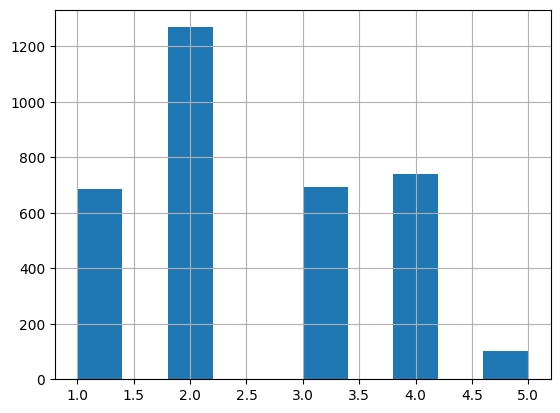

In [ ]:
train["PitchSatisfactionScore"].hist()

In [ ]:
# 2〜3が高い
print(train.loc[train["PitchSatisfactionScore"]==1,"ProdTaken"].mean())
print(train.loc[train["PitchSatisfactionScore"]==2,"ProdTaken"].mean())
print(train.loc[train["PitchSatisfactionScore"]==3,"ProdTaken"].mean())
print(train.loc[train["PitchSatisfactionScore"]==4,"ProdTaken"].mean())
print(train.loc[train["PitchSatisfactionScore"]==5,"ProdTaken"].mean())
# print(train.loc[(train["PitchSatisfactionScore"]<=3)&(train["PitchSatisfactionScore"]<2),"ProdTaken"].mean())

0.08017492711370262
0.17494089834515367
0.1416184971098266
0.15155615696887687
0.0970873786407767


<Axes: >

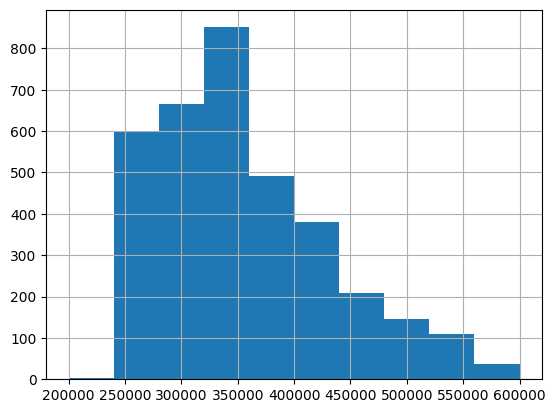

In [ ]:
train["MonthlyIncome"].hist()

In [ ]:
# Log取るか、月収低すぎを異常値とするか
print(train.loc[train["MonthlyIncome"]<250000,"ProdTaken"].mean())
print(train.loc[(train["MonthlyIncome"]>=250000)&(train["MonthlyIncome"]<300000),"ProdTaken"].mean())
print(train.loc[(train["MonthlyIncome"]>=300000)&(train["MonthlyIncome"]<350000),"ProdTaken"].mean())
print(train.loc[(train["MonthlyIncome"]>=350000)&(train["MonthlyIncome"]<400000),"ProdTaken"].mean())
print(train.loc[(train["MonthlyIncome"]>=400000)&(train["MonthlyIncome"]<450000),"ProdTaken"].mean())
print(train.loc[(train["MonthlyIncome"]>=450000)&(train["MonthlyIncome"]<500000),"ProdTaken"].mean())
print(train.loc[train["MonthlyIncome"]>=500000,"ProdTaken"].mean())

0.4444444444444444
0.3378995433789954
0.11547911547911548
0.06960227272727272
0.08256880733944955
0.06698564593301436
0.09787234042553192


<Axes: >

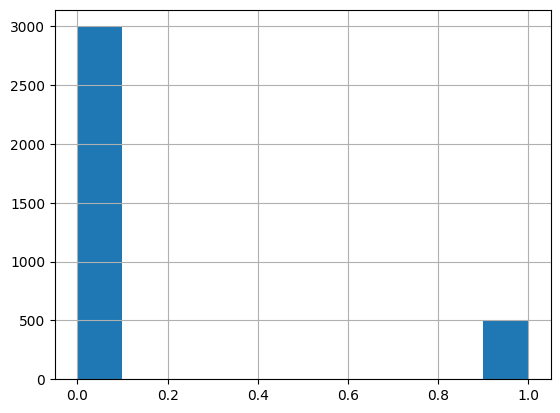

In [ ]:
all_df["ProdTaken"].hist()

In [ ]:
# 月収はLogを取る
# all_df["MonthlyIncomeLOG"] = np.log1p(all_df["MonthlyIncome"])

In [ ]:
# 年齢はLogを取る
# all_df["AgeLOG"] = np.log1p(all_df["Age"])

In [165]:
# 検討の結果、重要度が低いものを抹消する(gain=0)
all_df = all_df.drop("Gender_LE", axis=1)

In [ ]:
# 抹消対象だがまずは置いて
# all_df = all_df.drop("Age", axis=1)
# all_df = all_df.drop("MonthlyIncome", axis=1)

In [187]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [188]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)

In [189]:
# カラムを制限
all_df2 = all_df[FEATURES]

In [190]:
# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

In [191]:
# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)

In [192]:
FEATURES = test.columns

In [193]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.7177861300160412,
    'num_leaves': 100,
    'bagging_fraction': 0.42936413368667514,
    'bagging_freq': 7,
    'lambda_l1': 8.134448301407863,
    'lambda_l2': 9.742577954650878,
    'min_data_in_leaf': 96,
    'learning_rate': 0.02551719491742634,
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [194]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=74)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

#########################
### Fold 1
#########################
[100]	train's auc: 0.828934	valid's auc: 0.823815
[200]	train's auc: 0.837426	valid's auc: 0.826072
[300]	train's auc: 0.84459	valid's auc: 0.826192
[400]	train's auc: 0.847555	valid's auc: 0.827235
#########################
### Fold 2
#########################
[100]	train's auc: 0.834462	valid's auc: 0.811643
[200]	train's auc: 0.844799	valid's auc: 0.82086
[300]	train's auc: 0.851235	valid's auc: 0.82254
#########################
### Fold 3
#########################
[100]	train's auc: 0.830876	valid's auc: 0.810509
[200]	train's auc: 0.841605	valid's auc: 0.81783
[300]	train's auc: 0.846104	valid's auc: 0.820517
[400]	train's auc: 0.849565	valid's auc: 0.822551
[500]	train's auc: 0.85332	valid's auc: 0.82331
[600]	train's auc: 0.856041	valid's auc: 0.82512
[700]	train's auc: 0.858754	valid's auc: 0.826468
0.8241016957359129
CPU times: user 4.62 s, sys: 548 ms, total: 5.17 s
Wall time: 1.34 s


In [195]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8241016957359129


<Axes: >

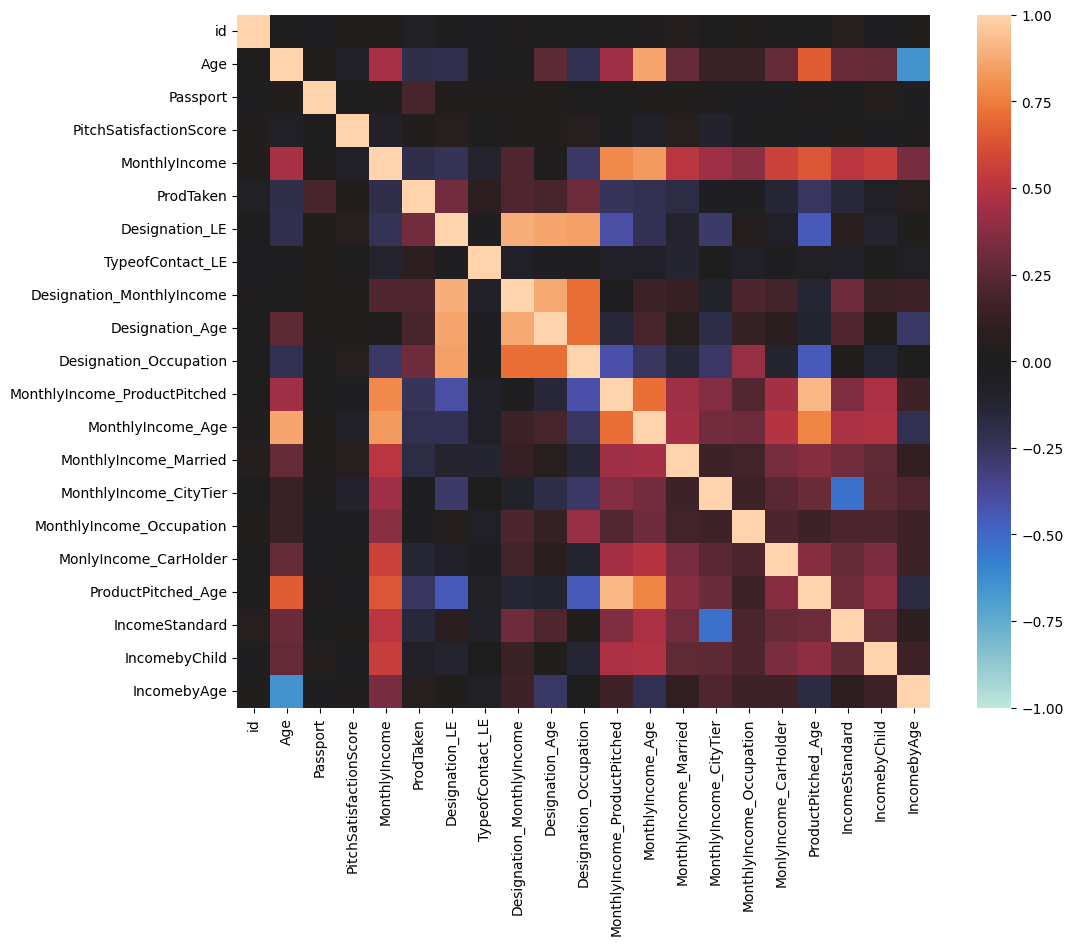

In [175]:
all_df_corr = all_df.corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(all_df_corr, square=True, vmax=1, vmin=-1, center=0)

In [ ]:
# スコアが上がる振り分けSeedを探す

In [ ]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score # AUC評価指標

# SEEDごとのスコアを出す
def objective(seed):

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  FOLDS = 3 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

  # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    #データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    models.append(model_lgb)

  # AUCの評価(第一引数にy_trueを入れる)
  score = roc_auc_score(train[TARGET],oof_lgb)
  return score

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 21 µs


In [ ]:
# seedが0〜99まで試す
score_history = []

for i in range(100):
  score_history.append(objective(i))

#########################
### Fold 1
#########################
[100]	train's auc: 0.854946	valid's auc: 0.852521
[200]	train's auc: 0.869279	valid's auc: 0.849531
#########################
### Fold 2
#########################
[100]	train's auc: 0.862999	valid's auc: 0.814455
[200]	train's auc: 0.876528	valid's auc: 0.81825
[300]	train's auc: 0.887017	valid's auc: 0.81944
[400]	train's auc: 0.895676	valid's auc: 0.819839
[500]	train's auc: 0.899424	valid's auc: 0.82048
[600]	train's auc: 0.904539	valid's auc: 0.8206
#########################
### Fold 3
#########################
[100]	train's auc: 0.865547	valid's auc: 0.815364
#########################
### Fold 1
#########################
[100]	train's auc: 0.860219	valid's auc: 0.834352
[200]	train's auc: 0.873183	valid's auc: 0.837917
[300]	train's auc: 0.883352	valid's auc: 0.837603
[400]	train's auc: 0.890395	valid's auc: 0.837742
#########################
### Fold 2
#########################
[100]	train's auc: 0.85736	valid's auc: 

In [ ]:
max_val = max(score_history)
max_index = score_history.index(max_val)
print(max_index)
print(max_val)

74
0.834673818310935


In [ ]:
score_history[0]

np.float64(0.8270680231119336)

In [ ]:
max(score_history)

np.float64(0.834673818310935)

In [ ]:
# FOLDS = 3 # 分割数
# skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

# skf_trainIND = []
# skf_validIND = []

# for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
#   skf_trainIND.append(train_index)
#   skf_validIND.append(test_index)

In [ ]:
# # FOLDごとのdfを分ける
# train_FOLD1 = all_df.loc[skf_trainIND[0]]
# train_FOLD2 = all_df.loc[skf_trainIND[2]]
# train_FOLD3 = all_df.loc[skf_trainIND[4]]
# test_FOLD1 = all_df.loc[skf_trainIND[1]]
# test_FOLD2 = all_df.loc[skf_trainIND[3]]
# test_FOLD3 = all_df.loc[skf_trainIND[5]]

In [ ]:
# print(skf_trainIND[0])
# print(skf_validIND[0])
# print(skf_trainIND[1])
# print(skf_validIND[1])
# print(skf_trainIND[2])
# print(skf_validIND[2])

[   0    3    4 ... 3485 3486 3488]
[   1    2   16 ... 3478 3480 3487]
[   0    1    2 ... 3485 3487 3488]
[   3    4    5 ... 3482 3483 3486]
[   1    2    3 ... 3483 3486 3487]
[   0    6   13 ... 3484 3485 3488]


In [ ]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8312185949924144


In [61]:
# FOLD1
# lgb.plot_importance(models[0], figsize=(8,4), max_num_features=20, importance_type='gain')
importance0 = pd.DataFrame(models[0].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance1 = pd.DataFrame(models[1].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance2 = pd.DataFrame(models[2].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])

In [62]:
feature = (importance0+importance1+importance2)/3

In [63]:
feature.sort_values("importance", ascending=False)

,importance
ProductPitched_Age,804.381059
MonthlyIncome_ProductPitched,571.687109
Designation_LE,463.226651
MonthlyIncome_Married,432.457818
Passport,318.568518
MonthlyIncome_Age,264.245205
IncomeStandard,222.578182
Designation_MonthlyIncome,157.943846
MonthlyIncome_CityTier,151.972332
MonthlyIncome,112.368767


In [65]:
import shap
shap.initjs()
# 基本スコア
explainer = shap.TreeExplainer(model=models[0])

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


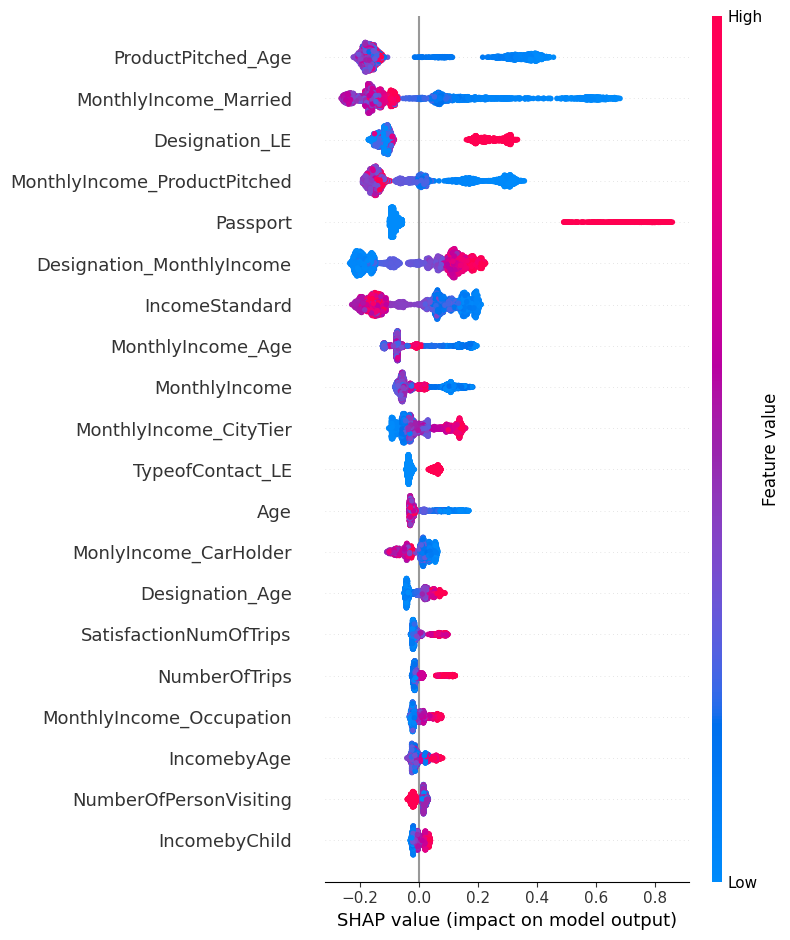

In [66]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt

# 学習済みのモデル（例：lgb_model）
# 学習に使った特徴量データ（例：X_train）

# 横軸：SHAP値 (0からの貢献度、右=プラスの影響)
# 縦軸：特徴量 (上にあるほど重要)
# 色：その特徴の値 (赤=大きい値、青=小さい値)

# ① SHAPのexplainerを作成
explainer = shap.TreeExplainer(models[0])

# ② SHAP値を計算（X_trainは学習に使った特徴量データ）
shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))

# ③ summary plotで全体の重要度と分布を見る
shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

In [180]:
all_df.columns

Index(['id', 'Age', 'Passport', 'PitchSatisfactionScore', 'MonthlyIncome',
       'ProdTaken', 'Designation_LE', 'TypeofContact_LE',
       'Designation_MonthlyIncome', 'Designation_Age',
       'Designation_Occupation', 'MonthlyIncome_ProductPitched',
       'MonthlyIncome_Age', 'MonthlyIncome_Married', 'MonthlyIncome_CityTier',
       'MonthlyIncome_Occupation', 'MonlyIncome_CarHolder',
       'ProductPitched_Age', 'IncomeStandard', 'IncomebyChild', 'IncomebyAge'],
      dtype='object')

In [196]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def objective(trial):

  lgbm_params = {
      'objective': 'binary',
      "device": "cpu",
      'metric': 'auc',
      # 'metric': 'rmse',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
      'num_leaves': trial.suggest_int('num_leaves', 2, 256), # 20回
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      # 'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1), # 2回目
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
      'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      # 'max_depth': trial.suggest_int('max_depth', 3, 12),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  score = roc_auc_score(train[TARGET],oof_lgb)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-22 15:50:49,728] A new study created in memory with name: no-name-4808d68f-b1a0-4c42-8d61-dc096bc23ff5
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.920482	valid's auc: 0.828404
#########################
### Fold 2
#########################
[100]	train's auc: 0.928116	valid's auc: 0.805673
#########################
### Fold 3
#########################
[100]	train's auc: 0.926437	valid's auc: 0.809124


[I 2025-05-22 15:50:51,760] Trial 0 finished with value: 0.7999460667749815 and parameters: {'feature_fraction': 0.9518860227494168, 'num_leaves': 222, 'bagging_fraction': 0.6477919537382205, 'bagging_freq': 4, 'lambda_l1': 0.48598349468636637, 'lambda_l2': 5.3349170916647966, 'min_data_in_leaf': 6, 'learning_rate': 0.020802128576640624}. Best is trial 0 with value: 0.7999460667749815.


[200]	train's auc: 0.961152	valid's auc: 0.809149
#########################
### Fold 1
#########################
[100]	train's auc: 0.827692	valid's auc: 0.812353


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.837143	valid's auc: 0.815129
[300]	train's auc: 0.846018	valid's auc: 0.821096
[400]	train's auc: 0.85285	valid's auc: 0.823688
[500]	train's auc: 0.8585	valid's auc: 0.825304
[600]	train's auc: 0.862471	valid's auc: 0.826156
[700]	train's auc: 0.866094	valid's auc: 0.826875
[800]	train's auc: 0.869159	valid's auc: 0.827498
#########################
### Fold 2
#########################
[100]	train's auc: 0.838926	valid's auc: 0.808075
[200]	train's auc: 0.847428	valid's auc: 0.810147
[300]	train's auc: 0.855652	valid's auc: 0.813395
[400]	train's auc: 0.862189	valid's auc: 0.815211
[500]	train's auc: 0.866377	valid's auc: 0.815489
[600]	train's auc: 0.870468	valid's auc: 0.815854
[700]	train's auc: 0.873333	valid's auc: 0.816307
#########################
### Fold 3
#########################
[100]	train's auc: 0.837132	valid's auc: 0.790353
[200]	train's auc: 0.843759	valid's auc: 0.796293
[300]	train's auc: 0.850808	valid's auc: 0.802724
[400]	train's auc: 0.85667	

[I 2025-05-22 15:50:55,341] Trial 1 finished with value: 0.8192904082247494 and parameters: {'feature_fraction': 0.6951900250100962, 'num_leaves': 49, 'bagging_fraction': 0.8358243859197946, 'bagging_freq': 4, 'lambda_l1': 7.725297103835606, 'lambda_l2': 8.890213688757854, 'min_data_in_leaf': 27, 'learning_rate': 0.005896201790866137}. Best is trial 1 with value: 0.8192904082247494.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0

#########################
### Fold 1
#########################
[100]	train's auc: 0.817454	valid's auc: 0.809165
#########################
### Fold 2
#########################


[I 2025-05-22 15:50:55,707] Trial 2 finished with value: 0.7988959828489655 and parameters: {'feature_fraction': 0.5410521881974448, 'num_leaves': 239, 'bagging_fraction': 0.4762393480292063, 'bagging_freq': 2, 'lambda_l1': 6.782278994570644, 'lambda_l2': 4.597381772083484, 'min_data_in_leaf': 44, 'learning_rate': 0.002404404725364785}. Best is trial 1 with value: 0.8192904082247494.


[100]	train's auc: 0.825718	valid's auc: 0.808652
#########################
### Fold 3
#########################
[100]	train's auc: 0.829427	valid's auc: 0.795278
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.820403	valid's auc: 0.798909
[200]	train's auc: 0.826378	valid's auc: 0.80277
[300]	train's auc: 0.837646	valid's auc: 0.81289
[400]	train's auc: 0.846615	valid's auc: 0.819519
[500]	train's auc: 0.853134	valid's auc: 0.823174
#########################
### Fold 2
#########################
[100]	train's auc: 0.833381	valid's auc: 0.794078
[200]	train's auc: 0.841517	valid's auc: 0.805613
#########################
### Fold 3
#########################
[100]	train's auc: 0.830655	valid's auc: 0.774932
[200]	train's auc: 0.833006	valid's auc: 0.777628
[300]	train's auc: 0.841758	valid's auc: 0.791565
[400]	train's auc: 0.84735	valid's auc: 0.796617
[500]	train's auc: 0.85164	valid's auc: 0.799186
[600]	train's auc: 0.856048	valid's auc: 0.801952
[700]	train's auc: 0.860265	valid's auc: 0.8059
[800]	train's auc: 0.863813	valid's auc: 0.808386
[900]	train's auc: 0.867073	valid's auc: 0.81077
[1000]	train's auc: 0.869938	valid's auc: 0.812637
[1100]	train's auc: 0.872738	v

[I 2025-05-22 15:50:58,979] Trial 3 finished with value: 0.7988324331012815 and parameters: {'feature_fraction': 0.9751930976816722, 'num_leaves': 114, 'bagging_fraction': 0.8917909656362976, 'bagging_freq': 7, 'lambda_l1': 3.5254435090231024, 'lambda_l2': 9.576329653378673, 'min_data_in_leaf': 53, 'learning_rate': 0.0026106407991993963}. Best is trial 1 with value: 0.8192904082247494.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4

#########################
### Fold 1
#########################
[100]	train's auc: 0.896293	valid's auc: 0.825265
#########################
### Fold 2
#########################
[100]	train's auc: 0.905026	valid's auc: 0.814232
#########################
### Fold 3
#########################
[100]	train's auc: 0.897004	valid's auc: 0.821312


[I 2025-05-22 15:50:59,576] Trial 4 finished with value: 0.8233686880642141 and parameters: {'feature_fraction': 0.7398124692467307, 'num_leaves': 139, 'bagging_fraction': 0.7339657509571011, 'bagging_freq': 1, 'lambda_l1': 3.284250639810542, 'lambda_l2': 1.2271807627880427, 'min_data_in_leaf': 80, 'learning_rate': 0.06443443685148922}. Best is trial 4 with value: 0.8233686880642141.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 

#########################
### Fold 1
#########################
[100]	train's auc: 0.876514	valid's auc: 0.819948
#########################
### Fold 2
#########################
[100]	train's auc: 0.885864	valid's auc: 0.808984
[200]	train's auc: 0.889051	valid's auc: 0.809443
[300]	train's auc: 0.892036	valid's auc: 0.810909
[400]	train's auc: 0.894903	valid's auc: 0.811552
[500]	train's auc: 0.897939	valid's auc: 0.811585
[600]	train's auc: 0.901054	valid's auc: 0.811634
#########################
### Fold 3
#########################
[100]	train's auc: 0.879647	valid's auc: 0.800073


[I 2025-05-22 15:51:04,803] Trial 5 finished with value: 0.7764316514057608 and parameters: {'feature_fraction': 0.46332148118603855, 'num_leaves': 41, 'bagging_fraction': 0.8130687258264115, 'bagging_freq': 2, 'lambda_l1': 0.26394294313191574, 'lambda_l2': 5.105197635708325, 'min_data_in_leaf': 5, 'learning_rate': 0.0012290704232152307}. Best is trial 4 with value: 0.8233686880642141.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4

#########################
### Fold 1
#########################
[100]	train's auc: 0.836108	valid's auc: 0.816794
[200]	train's auc: 0.85237	valid's auc: 0.824564
[300]	train's auc: 0.859059	valid's auc: 0.826664
[400]	train's auc: 0.863883	valid's auc: 0.826232
#########################
### Fold 2
#########################
[100]	train's auc: 0.844305	valid's auc: 0.813292
[200]	train's auc: 0.857093	valid's auc: 0.817984
[300]	train's auc: 0.863075	valid's auc: 0.820697
[400]	train's auc: 0.867014	valid's auc: 0.821334
[500]	train's auc: 0.869483	valid's auc: 0.821945
[600]	train's auc: 0.870626	valid's auc: 0.821975
[700]	train's auc: 0.871474	valid's auc: 0.822114
#########################
### Fold 3
#########################
[100]	train's auc: 0.842658	valid's auc: 0.802174
[200]	train's auc: 0.853957	valid's auc: 0.813779
[300]	train's auc: 0.860009	valid's auc: 0.818167
[400]	train's auc: 0.863761	valid's auc: 0.819654


[I 2025-05-22 15:51:06,437] Trial 6 finished with value: 0.8220593615166938 and parameters: {'feature_fraction': 0.4291145687542759, 'num_leaves': 26, 'bagging_fraction': 0.9568505704723269, 'bagging_freq': 2, 'lambda_l1': 9.786499474288012, 'lambda_l2': 7.15801830891013, 'min_data_in_leaf': 53, 'learning_rate': 0.016185072442862634}. Best is trial 4 with value: 0.8233686880642141.


[500]	train's auc: 0.865738	valid's auc: 0.821197
[600]	train's auc: 0.867087	valid's auc: 0.821027
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.888314	valid's auc: 0.82189
#########################
### Fold 2
#########################
[100]	train's auc: 0.894875	valid's auc: 0.814634
#########################
### Fold 3
#########################
[100]	train's auc: 0.888354	valid's auc: 0.820489


[I 2025-05-22 15:51:07,050] Trial 7 finished with value: 0.8164626125738388 and parameters: {'feature_fraction': 0.5973690667103285, 'num_leaves': 111, 'bagging_fraction': 0.9908705787264858, 'bagging_freq': 1, 'lambda_l1': 1.632768445695616, 'lambda_l2': 4.708552189263904, 'min_data_in_leaf': 89, 'learning_rate': 0.03775048923482251}. Best is trial 4 with value: 0.8233686880642141.


[200]	train's auc: 0.924483	valid's auc: 0.819861
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.969796	valid's auc: 0.80593
#########################
### Fold 2
#########################
[100]	train's auc: 0.972533	valid's auc: 0.792441
#########################
### Fold 3
#########################


[I 2025-05-22 15:51:07,913] Trial 8 finished with value: 0.8065296861382196 and parameters: {'feature_fraction': 0.7714003456582124, 'num_leaves': 205, 'bagging_fraction': 0.7322960769463286, 'bagging_freq': 4, 'lambda_l1': 1.347231088739719, 'lambda_l2': 2.0811779069793332, 'min_data_in_leaf': 12, 'learning_rate': 0.05555342626835838}. Best is trial 4 with value: 0.8233686880642141.


[100]	train's auc: 0.970872	valid's auc: 0.817438
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.857839	valid's auc: 0.827492
#########################
### Fold 2
#########################
[100]	train's auc: 0.866305	valid's auc: 0.812066
[200]	train's auc: 0.870403	valid's auc: 0.815211
#########################
### Fold 3
#########################


[I 2025-05-22 15:51:08,602] Trial 9 finished with value: 0.7990348508161267 and parameters: {'feature_fraction': 0.7377168084754543, 'num_leaves': 191, 'bagging_fraction': 0.5625553256940258, 'bagging_freq': 6, 'lambda_l1': 2.9415226814188675, 'lambda_l2': 0.08004882347881957, 'min_data_in_leaf': 24, 'learning_rate': 0.0034439844415026836}. Best is trial 4 with value: 0.8233686880642141.


[100]	train's auc: 0.859555	valid's auc: 0.806152
#########################
### Fold 1
#########################
[100]	train's auc: 0.812487	valid's auc: 0.806093
#########################
### Fold 2
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
[I 2025-05-22 15:51:09,033] Trial 10 finished with value: 0.7680249276407106 and parameters: {'feature_fraction': 0.8287263989036475, 'num_leaves': 149, 'bagging_fraction': 0.4050147257529077, 'bagging_freq': 1, 'lambda_l1': 5.205604855365946, 'lambda_l2': 0.09041328196672116, 'min_data_in_leaf': 93, 'learning_rate': 0.00014693778082451906}. Best is trial 4 with value: 0.8233686

[100]	train's auc: 0.815955	valid's auc: 0.794217
#########################
### Fold 3
#########################
[100]	train's auc: 0.81744	valid's auc: 0.797805


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.870384	valid's auc: 0.823437
#########################
### Fold 2
#########################
[100]	train's auc: 0.872632	valid's auc: 0.82212
#########################
### Fold 3
#########################
[100]	train's auc: 0.868502	valid's auc: 0.826052


[I 2025-05-22 15:51:09,532] Trial 11 finished with value: 0.8232799201626873 and parameters: {'feature_fraction': 0.409013707108452, 'num_leaves': 6, 'bagging_fraction': 0.9933179986720286, 'bagging_freq': 2, 'lambda_l1': 5.439204908065912, 'lambda_l2': 7.675884215891525, 'min_data_in_leaf': 75, 'learning_rate': 0.09608048035573445}. Best is trial 4 with value: 0.8233686880642141.


[200]	train's auc: 0.87922	valid's auc: 0.825156
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.891077	valid's auc: 0.822724
#########################
### Fold 2
#########################
[100]	train's auc: 0.899191	valid's auc: 0.815764
#########################
### Fold 3
#########################


[I 2025-05-22 15:51:10,104] Trial 12 finished with value: 0.8196710342267508 and parameters: {'feature_fraction': 0.6074446693448412, 'num_leaves': 151, 'bagging_fraction': 0.6772792441544877, 'bagging_freq': 3, 'lambda_l1': 3.908243710228726, 'lambda_l2': 2.574760756696535, 'min_data_in_leaf': 75, 'learning_rate': 0.08517081224589504}. Best is trial 4 with value: 0.8233686880642141.


[100]	train's auc: 0.893186	valid's auc: 0.823851
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.889439	valid's auc: 0.822241
#########################
### Fold 2
#########################
[100]	train's auc: 0.895737	valid's auc: 0.811223
#########################
### Fold 3
#########################
[100]	train's auc: 0.8885	valid's auc: 0.82505
[200]	train's auc: 0.914518	valid's auc: 0.819661


[I 2025-05-22 15:51:10,666] Trial 13 finished with value: 0.8222994383412776 and parameters: {'feature_fraction': 0.8582822281840683, 'num_leaves': 74, 'bagging_fraction': 0.7693185259897672, 'bagging_freq': 1, 'lambda_l1': 5.487903191736019, 'lambda_l2': 7.547810385517873, 'min_data_in_leaf': 74, 'learning_rate': 0.0987298949254496}. Best is trial 4 with value: 0.8233686880642141.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.

#########################
### Fold 1
#########################
[100]	train's auc: 0.840976	valid's auc: 0.820117
[200]	train's auc: 0.856092	valid's auc: 0.826371
[300]	train's auc: 0.863875	valid's auc: 0.828307
[400]	train's auc: 0.871013	valid's auc: 0.827171
#########################
### Fold 2
#########################
[100]	train's auc: 0.848559	valid's auc: 0.815579
[200]	train's auc: 0.863015	valid's auc: 0.818165
[300]	train's auc: 0.870767	valid's auc: 0.817673
#########################
### Fold 3
#########################
[100]	train's auc: 0.844735	valid's auc: 0.801734
[200]	train's auc: 0.858672	valid's auc: 0.81438
[300]	train's auc: 0.86638	valid's auc: 0.819002
[400]	train's auc: 0.8722	valid's auc: 0.821288
[500]	train's auc: 0.877409	valid's auc: 0.821507
[600]	train's auc: 0.881343	valid's auc: 0.822278
[700]	train's auc: 0.884908	valid's auc: 0.823043
[800]	train's auc: 0.887324	valid's auc: 0.822752


[I 2025-05-22 15:51:12,287] Trial 14 finished with value: 0.8210368494388792 and parameters: {'feature_fraction': 0.6403790662019456, 'num_leaves': 84, 'bagging_fraction': 0.8988158764860433, 'bagging_freq': 3, 'lambda_l1': 7.222150446848849, 'lambda_l2': 2.6687454710119543, 'min_data_in_leaf': 73, 'learning_rate': 0.012807178866918}. Best is trial 4 with value: 0.8233686880642141.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.

#########################
### Fold 1
#########################
[100]	train's auc: 0.826017	valid's auc: 0.811471
#########################
### Fold 2
#########################
[100]	train's auc: 0.825692	valid's auc: 0.805712
[200]	train's auc: 0.825709	valid's auc: 0.807153
#########################
### Fold 3
#########################
[100]	train's auc: 0.83013	valid's auc: 0.796891


[I 2025-05-22 15:51:12,799] Trial 15 finished with value: 0.7680874686622409 and parameters: {'feature_fraction': 0.5403486372532943, 'num_leaves': 6, 'bagging_fraction': 0.597951367725011, 'bagging_freq': 3, 'lambda_l1': 2.5348658302771745, 'lambda_l2': 7.4131924811919925, 'min_data_in_leaf': 99, 'learning_rate': 0.000456459517970184}. Best is trial 4 with value: 0.8233686880642141.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 

#########################
### Fold 1
#########################
[100]	train's auc: 0.865802	valid's auc: 0.824202
[200]	train's auc: 0.888445	valid's auc: 0.825029
#########################
### Fold 2
#########################
[100]	train's auc: 0.874486	valid's auc: 0.813839
#########################
### Fold 3
#########################
[100]	train's auc: 0.867967	valid's auc: 0.815905


[I 2025-05-22 15:51:16,383] Trial 16 finished with value: 0.818397685578713 and parameters: {'feature_fraction': 0.8740754567580491, 'num_leaves': 177, 'bagging_fraction': 0.901789416531958, 'bagging_freq': 5, 'lambda_l1': 4.873930650043646, 'lambda_l2': 6.29242739922803, 'min_data_in_leaf': 64, 'learning_rate': 0.029445046763349084}. Best is trial 4 with value: 0.8233686880642141.


[200]	train's auc: 0.888763	valid's auc: 0.820207
[300]	train's auc: 0.904747	valid's auc: 0.820723
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.83153	valid's auc: 0.819138
[200]	train's auc: 0.841437	valid's auc: 0.823413
[300]	train's auc: 0.849364	valid's auc: 0.825703
[400]	train's auc: 0.855115	valid's auc: 0.826779
#########################
### Fold 2
#########################
[100]	train's auc: 0.832282	valid's auc: 0.813171
[200]	train's auc: 0.844958	valid's auc: 0.820087
[300]	train's auc: 0.852863	valid's auc: 0.822579
[400]	train's auc: 0.858879	valid's auc: 0.82438
[500]	train's auc: 0.863945	valid's auc: 0.825156
#########################
### Fold 3
#########################
[100]	train's auc: 0.836598	valid's auc: 0.804958
[200]	train's auc: 0.843951	valid's auc: 0.814447
[300]	train's auc: 0.849489	valid's auc: 0.81858
[400]	train's auc: 0.854175	valid's auc: 0.821871
[500]	train's auc: 0.85858	valid's auc: 0.823298
[600]	train's auc: 0.862324	valid's auc: 0.824276


[I 2025-05-22 15:51:18,207] Trial 17 finished with value: 0.8245307405932925 and parameters: {'feature_fraction': 0.40372727382715057, 'num_leaves': 82, 'bagging_fraction': 0.5553106138054712, 'bagging_freq': 2, 'lambda_l1': 4.255751261844733, 'lambda_l2': 3.555236871577515, 'min_data_in_leaf': 84, 'learning_rate': 0.010328055277048307}. Best is trial 17 with value: 0.8245307405932925.


[700]	train's auc: 0.865962	valid's auc: 0.825357
[800]	train's auc: 0.869768	valid's auc: 0.825642


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.829402	valid's auc: 0.818452
[200]	train's auc: 0.842062	valid's auc: 0.823763
[300]	train's auc: 0.848822	valid's auc: 0.825914
[400]	train's auc: 0.853885	valid's auc: 0.82741
[500]	train's auc: 0.858783	valid's auc: 0.827102
#########################
### Fold 2
#########################
[100]	train's auc: 0.835823	valid's auc: 0.815576
[200]	train's auc: 0.846838	valid's auc: 0.820063
[300]	train's auc: 0.853916	valid's auc: 0.822425
[400]	train's auc: 0.859392	valid's auc: 0.823259
#########################
### Fold 3
#########################
[100]	train's auc: 0.835948	valid's auc: 0.799617
[200]	train's auc: 0.842706	valid's auc: 0.80801
[300]	train's auc: 0.848622	valid's auc: 0.815294
[400]	train's auc: 0.853691	valid's auc: 0.81922
[500]	train's auc: 0.85755	valid's auc: 0.821422
[600]	train's auc: 0.861676	valid's auc: 0.822381
[700]	train's auc: 0.865483	valid's auc: 0.822855


[I 2025-05-22 15:51:20,042] Trial 18 finished with value: 0.8227900154940336 and parameters: {'feature_fraction': 0.6709057913127761, 'num_leaves': 87, 'bagging_fraction': 0.5272377008769427, 'bagging_freq': 1, 'lambda_l1': 4.182259155502815, 'lambda_l2': 1.5499170544220693, 'min_data_in_leaf': 86, 'learning_rate': 0.007861932207800256}. Best is trial 17 with value: 0.8245307405932925.


[800]	train's auc: 0.86924	valid's auc: 0.823359
[900]	train's auc: 0.87297	valid's auc: 0.823535


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.833401	valid's auc: 0.817129
[200]	train's auc: 0.833635	valid's auc: 0.816492
#########################
### Fold 2
#########################
[100]	train's auc: 0.835609	valid's auc: 0.815274
#########################
### Fold 3
#########################


[I 2025-05-22 15:51:20,601] Trial 19 finished with value: 0.781033796361054 and parameters: {'feature_fraction': 0.5251491121629447, 'num_leaves': 141, 'bagging_fraction': 0.6527089575575145, 'bagging_freq': 3, 'lambda_l1': 2.3912673505419946, 'lambda_l2': 3.489936191025188, 'min_data_in_leaf': 65, 'learning_rate': 0.0010824581934783047}. Best is trial 17 with value: 0.8245307405932925.


[100]	train's auc: 0.835544	valid's auc: 0.801111
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.828644	valid's auc: 0.817141
[200]	train's auc: 0.838715	valid's auc: 0.824041
[300]	train's auc: 0.847942	valid's auc: 0.82751
[400]	train's auc: 0.852547	valid's auc: 0.828676
[500]	train's auc: 0.856066	valid's auc: 0.828845
[600]	train's auc: 0.858442	valid's auc: 0.828718
#########################
### Fold 2
#########################
[100]	train's auc: 0.836889	valid's auc: 0.812045
[200]	train's auc: 0.846716	valid's auc: 0.816262
[300]	train's auc: 0.853802	valid's auc: 0.8178
[400]	train's auc: 0.858516	valid's auc: 0.820038
[500]	train's auc: 0.862645	valid's auc: 0.821924
[600]	train's auc: 0.864606	valid's auc: 0.821419
#########################
### Fold 3
#########################
[100]	train's auc: 0.834692	valid's auc: 0.795096
[200]	train's auc: 0.843829	valid's auc: 0.805453
[300]	train's auc: 0.849304	valid's auc: 0.811134
[400]	train's auc: 0.853703	valid's auc: 0.815325
[500]	train's auc: 0.856672	valid's auc: 0.817177
[600]	train's auc: 0.859978

[I 2025-05-22 15:51:23,415] Trial 20 finished with value: 0.82167806303059 and parameters: {'feature_fraction': 0.7609638590335353, 'num_leaves': 173, 'bagging_fraction': 0.4710827132821884, 'bagging_freq': 2, 'lambda_l1': 8.330146004659044, 'lambda_l2': 1.143578105355652, 'min_data_in_leaf': 41, 'learning_rate': 0.010201002527806084}. Best is trial 17 with value: 0.8245307405932925.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 

#########################
### Fold 1
#########################
[100]	train's auc: 0.859451	valid's auc: 0.828383
[200]	train's auc: 0.876066	valid's auc: 0.824733
#########################
### Fold 2
#########################
[100]	train's auc: 0.866626	valid's auc: 0.821821
#########################
### Fold 3
#########################
[100]	train's auc: 0.861127	valid's auc: 0.820049
[200]	train's auc: 0.876644	valid's auc: 0.822885
[300]	train's auc: 0.888701	valid's auc: 0.824397


[I 2025-05-22 15:51:24,238] Trial 21 finished with value: 0.8239080203143997 and parameters: {'feature_fraction': 0.4387837730802234, 'num_leaves': 59, 'bagging_fraction': 0.7287179730167921, 'bagging_freq': 2, 'lambda_l1': 5.916785379306856, 'lambda_l2': 3.751543677834443, 'min_data_in_leaf': 81, 'learning_rate': 0.04679030445844531}. Best is trial 17 with value: 0.8245307405932925.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 

#########################
### Fold 1
#########################
[100]	train's auc: 0.855164	valid's auc: 0.828908
[200]	train's auc: 0.872989	valid's auc: 0.827528
#########################
### Fold 2
#########################
[100]	train's auc: 0.86366	valid's auc: 0.821748
#########################
### Fold 3
#########################
[100]	train's auc: 0.858373	valid's auc: 0.818546


[I 2025-05-22 15:51:24,995] Trial 22 finished with value: 0.8225499386694499 and parameters: {'feature_fraction': 0.4870283955013781, 'num_leaves': 117, 'bagging_fraction': 0.7447963552838385, 'bagging_freq': 1, 'lambda_l1': 6.1629251885304726, 'lambda_l2': 3.5979227711843444, 'min_data_in_leaf': 81, 'learning_rate': 0.03901398581043504}. Best is trial 17 with value: 0.8245307405932925.


[200]	train's auc: 0.87264	valid's auc: 0.821798
[300]	train's auc: 0.882333	valid's auc: 0.822369
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.841136	valid's auc: 0.825356
[200]	train's auc: 0.854873	valid's auc: 0.826534
[300]	train's auc: 0.863711	valid's auc: 0.826298
#########################
### Fold 2
#########################
[100]	train's auc: 0.845241	valid's auc: 0.81915
[200]	train's auc: 0.858134	valid's auc: 0.82151
[300]	train's auc: 0.867958	valid's auc: 0.823467
[400]	train's auc: 0.875529	valid's auc: 0.822552
#########################
### Fold 3
#########################
[100]	train's auc: 0.842793	valid's auc: 0.810649
[200]	train's auc: 0.855225	valid's auc: 0.822752
[300]	train's auc: 0.862758	valid's auc: 0.82427
[400]	train's auc: 0.869851	valid's auc: 0.825223
[500]	train's auc: 0.876298	valid's auc: 0.82563


[I 2025-05-22 15:51:29,170] Trial 23 finished with value: 0.824538810402522 and parameters: {'feature_fraction': 0.40665502285139216, 'num_leaves': 64, 'bagging_fraction': 0.6198285648212877, 'bagging_freq': 2, 'lambda_l1': 4.571300655193785, 'lambda_l2': 3.7351975432724696, 'min_data_in_leaf': 99, 'learning_rate': 0.02115222596478247}. Best is trial 23 with value: 0.824538810402522.


[600]	train's auc: 0.881869	valid's auc: 0.825843
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.84517	valid's auc: 0.824902
[200]	train's auc: 0.858211	valid's auc: 0.82396
#########################
### Fold 2
#########################
[100]	train's auc: 0.850224	valid's auc: 0.821579
[200]	train's auc: 0.862448	valid's auc: 0.822912
[300]	train's auc: 0.872486	valid's auc: 0.823498
#########################
### Fold 3
#########################
[100]	train's auc: 0.846607	valid's auc: 0.814966
[200]	train's auc: 0.858439	valid's auc: 0.822824
[300]	train's auc: 0.867172	valid's auc: 0.823905
[400]	train's auc: 0.875224	valid's auc: 0.824683


[I 2025-05-22 15:51:30,377] Trial 24 finished with value: 0.823150803215012 and parameters: {'feature_fraction': 0.40245579183127095, 'num_leaves': 69, 'bagging_fraction': 0.6180324811394275, 'bagging_freq': 3, 'lambda_l1': 4.407803654593516, 'lambda_l2': 3.739363069824095, 'min_data_in_leaf': 97, 'learning_rate': 0.02487648552567046}. Best is trial 23 with value: 0.824538810402522.


[500]	train's auc: 0.881401	valid's auc: 0.825691
[600]	train's auc: 0.888561	valid's auc: 0.824501
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.819477	valid's auc: 0.811597
[200]	train's auc: 0.824132	valid's auc: 0.816464
[300]	train's auc: 0.829109	valid's auc: 0.819011
[400]	train's auc: 0.834874	valid's auc: 0.822721
[500]	train's auc: 0.839104	valid's auc: 0.824075
[600]	train's auc: 0.841801	valid's auc: 0.82551
[700]	train's auc: 0.844076	valid's auc: 0.826271
[800]	train's auc: 0.846489	valid's auc: 0.82725
[900]	train's auc: 0.84864	valid's auc: 0.827866
[1000]	train's auc: 0.850641	valid's auc: 0.827782
[1100]	train's auc: 0.852287	valid's auc: 0.827872
#########################
### Fold 2
#########################
[100]	train's auc: 0.822311	valid's auc: 0.802368
[200]	train's auc: 0.828149	valid's auc: 0.807108
[300]	train's auc: 0.833726	valid's auc: 0.812628
[400]	train's auc: 0.838766	valid's auc: 0.816936
[500]	train's auc: 0.843044	valid's auc: 0.819567
[600]	train's auc: 0.846011	valid's auc: 0.820788
[700]	train's auc: 0.848714	valid's auc: 0.821652
[800]	train's auc: 0.851005	valid's au

[I 2025-05-22 15:51:34,077] Trial 25 finished with value: 0.8233246403555019 and parameters: {'feature_fraction': 0.4674123955583814, 'num_leaves': 55, 'bagging_fraction': 0.5448456222822788, 'bagging_freq': 2, 'lambda_l1': 6.200268449332086, 'lambda_l2': 6.022202803063529, 'min_data_in_leaf': 88, 'learning_rate': 0.004796317148937261}. Best is trial 23 with value: 0.824538810402522.


[1900]	train's auc: 0.860998	valid's auc: 0.822867
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.830367	valid's auc: 0.817325
[200]	train's auc: 0.844062	valid's auc: 0.822921
[300]	train's auc: 0.85131	valid's auc: 0.826754
[400]	train's auc: 0.857533	valid's auc: 0.826911
#########################
### Fold 2
#########################
[100]	train's auc: 0.837782	valid's auc: 0.811767
[200]	train's auc: 0.849856	valid's auc: 0.816824
[300]	train's auc: 0.858081	valid's auc: 0.820845
[400]	train's auc: 0.86382	valid's auc: 0.820984
[500]	train's auc: 0.867738	valid's auc: 0.821205
#########################
### Fold 3
#########################
[100]	train's auc: 0.838069	valid's auc: 0.798785
[200]	train's auc: 0.846247	valid's auc: 0.805411
[300]	train's auc: 0.85371	valid's auc: 0.814799
[400]	train's auc: 0.859242	valid's auc: 0.818416
[500]	train's auc: 0.863455	valid's auc: 0.819758
[600]	train's auc: 0.866858	valid's auc: 0.82048
[700]	train's auc: 0.870125	valid's auc: 0.821737
[800]	train's auc: 0.873406	valid's auc: 0.822217
[900]	train's auc: 0.876372	

[I 2025-05-22 15:51:36,186] Trial 26 finished with value: 0.8226144971432876 and parameters: {'feature_fraction': 0.49824069591910763, 'num_leaves': 94, 'bagging_fraction': 0.6980618646885463, 'bagging_freq': 5, 'lambda_l1': 6.170880838001127, 'lambda_l2': 4.0918769328824505, 'min_data_in_leaf': 64, 'learning_rate': 0.009921883567859014}. Best is trial 23 with value: 0.824538810402522.


[1100]	train's auc: 0.8819	valid's auc: 0.824179
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.845588	valid's auc: 0.830084
[200]	train's auc: 0.85412	valid's auc: 0.828419
#########################
### Fold 2
#########################
[100]	train's auc: 0.850476	valid's auc: 0.821981
[200]	train's auc: 0.857955	valid's auc: 0.823129
[300]	train's auc: 0.862965	valid's auc: 0.823431
#########################
### Fold 3
#########################
[100]	train's auc: 0.847022	valid's auc: 0.814848
[200]	train's auc: 0.855036	valid's auc: 0.820389
[300]	train's auc: 0.859539	valid's auc: 0.822287


[I 2025-05-22 15:51:37,209] Trial 27 finished with value: 0.822967215055036 and parameters: {'feature_fraction': 0.4421754178054607, 'num_leaves': 29, 'bagging_fraction': 0.5963377451083546, 'bagging_freq': 3, 'lambda_l1': 8.694070709039904, 'lambda_l2': 2.971283724378955, 'min_data_in_leaf': 100, 'learning_rate': 0.04204750248956557}. Best is trial 23 with value: 0.824538810402522.


[400]	train's auc: 0.862817	valid's auc: 0.822408
[500]	train's auc: 0.867169	valid's auc: 0.823332
[600]	train's auc: 0.867842	valid's auc: 0.823629


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.832374	valid's auc: 0.823631
[200]	train's auc: 0.847943	valid's auc: 0.829075
[300]	train's auc: 0.854072	valid's auc: 0.829374
#########################
### Fold 2
#########################
[100]	train's auc: 0.834988	valid's auc: 0.811993
[200]	train's auc: 0.849918	valid's auc: 0.81918
[300]	train's auc: 0.857619	valid's auc: 0.822643
[400]	train's auc: 0.864756	valid's auc: 0.822921
[500]	train's auc: 0.869068	valid's auc: 0.823773
[600]	train's auc: 0.874648	valid's auc: 0.822434
#########################
### Fold 3
#########################
[100]	train's auc: 0.833835	valid's auc: 0.806978
[200]	train's auc: 0.845293	valid's auc: 0.817168
[300]	train's auc: 0.851533	valid's auc: 0.820869
[400]	train's auc: 0.858629	valid's auc: 0.823571


[I 2025-05-22 15:51:38,551] Trial 28 finished with value: 0.8240078842036174 and parameters: {'feature_fraction': 0.5660973151070543, 'num_leaves': 64, 'bagging_fraction': 0.4818029045895365, 'bagging_freq': 5, 'lambda_l1': 4.4131620083957666, 'lambda_l2': 5.847736964441019, 'min_data_in_leaf': 93, 'learning_rate': 0.017413571550057384}. Best is trial 23 with value: 0.824538810402522.


[500]	train's auc: 0.86277	valid's auc: 0.825035
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.834338	valid's auc: 0.827114
[200]	train's auc: 0.848953	valid's auc: 0.830748
[300]	train's auc: 0.855324	valid's auc: 0.8316
#########################
### Fold 2
#########################
[100]	train's auc: 0.837361	valid's auc: 0.813984
[200]	train's auc: 0.853493	valid's auc: 0.82025
[300]	train's auc: 0.861497	valid's auc: 0.822262
[400]	train's auc: 0.868334	valid's auc: 0.822884
[500]	train's auc: 0.873107	valid's auc: 0.82277
#########################
### Fold 3
#########################
[100]	train's auc: 0.83615	valid's auc: 0.810667
[200]	train's auc: 0.848182	valid's auc: 0.818786
[300]	train's auc: 0.854892	valid's auc: 0.821057
[400]	train's auc: 0.862152	valid's auc: 0.8226
[500]	train's auc: 0.866514	valid's auc: 0.823335


[I 2025-05-22 15:51:42,572] Trial 29 finished with value: 0.8256759810198089 and parameters: {'feature_fraction': 0.5792396978665751, 'num_leaves': 98, 'bagging_fraction': 0.46176553525479547, 'bagging_freq': 5, 'lambda_l1': 4.582614554815408, 'lambda_l2': 5.88875297230717, 'min_data_in_leaf': 93, 'learning_rate': 0.020951450658969282}. Best is trial 29 with value: 0.8256759810198089.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,

#########################
### Fold 1
#########################
[100]	train's auc: 0.844828	valid's auc: 0.823791
[200]	train's auc: 0.857836	valid's auc: 0.824869
#########################
### Fold 2
#########################
[100]	train's auc: 0.848862	valid's auc: 0.818129
[200]	train's auc: 0.863945	valid's auc: 0.817927
#########################
### Fold 3
#########################
[100]	train's auc: 0.843952	valid's auc: 0.817028


[I 2025-05-22 15:51:43,347] Trial 30 finished with value: 0.8229379619965784 and parameters: {'feature_fraction': 0.5052853044469169, 'num_leaves': 98, 'bagging_fraction': 0.4479939068822996, 'bagging_freq': 6, 'lambda_l1': 1.2840772540388583, 'lambda_l2': 5.306645885346543, 'min_data_in_leaf': 94, 'learning_rate': 0.023837417794797016}. Best is trial 29 with value: 0.8256759810198089.


[200]	train's auc: 0.85899	valid's auc: 0.823262
[300]	train's auc: 0.871115	valid's auc: 0.825782
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.831559	valid's auc: 0.824911
[200]	train's auc: 0.847281	valid's auc: 0.830111
[300]	train's auc: 0.853971	valid's auc: 0.829159
#########################
### Fold 2
#########################
[100]	train's auc: 0.837298	valid's auc: 0.814531
[200]	train's auc: 0.850796	valid's auc: 0.819464
[300]	train's auc: 0.858267	valid's auc: 0.821389
[400]	train's auc: 0.865247	valid's auc: 0.820872
[500]	train's auc: 0.870471	valid's auc: 0.821694
#########################
### Fold 3
#########################
[100]	train's auc: 0.836876	valid's auc: 0.805465
[200]	train's auc: 0.846453	valid's auc: 0.815762
[300]	train's auc: 0.852634	valid's auc: 0.819503
[400]	train's auc: 0.859942	valid's auc: 0.821604
[500]	train's auc: 0.864531	valid's auc: 0.822381
[600]	train's auc: 0.868762	valid's auc: 0.823778


[I 2025-05-22 15:51:44,870] Trial 31 finished with value: 0.8230347997073351 and parameters: {'feature_fraction': 0.6019518046725988, 'num_leaves': 72, 'bagging_fraction': 0.5068227724146752, 'bagging_freq': 5, 'lambda_l1': 4.568108959318359, 'lambda_l2': 6.590531786229899, 'min_data_in_leaf': 90, 'learning_rate': 0.017323833238188535}. Best is trial 29 with value: 0.8256759810198089.


[700]	train's auc: 0.873483	valid's auc: 0.824343
[800]	train's auc: 0.878015	valid's auc: 0.824476
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.811627	valid's auc: 0.804096
[200]	train's auc: 0.829233	valid's auc: 0.820446
[300]	train's auc: 0.834111	valid's auc: 0.823268
[400]	train's auc: 0.838998	valid's auc: 0.824724
[500]	train's auc: 0.843123	valid's auc: 0.826229
[600]	train's auc: 0.846286	valid's auc: 0.826053
#########################
### Fold 2
#########################
[100]	train's auc: 0.821376	valid's auc: 0.800268
[200]	train's auc: 0.831016	valid's auc: 0.808398
[300]	train's auc: 0.838746	valid's auc: 0.816377
[400]	train's auc: 0.844289	valid's auc: 0.819174
[500]	train's auc: 0.848131	valid's auc: 0.820193
[600]	train's auc: 0.851299	valid's auc: 0.821498
[700]	train's auc: 0.854332	valid's auc: 0.821709
#########################
### Fold 3
#########################
[100]	train's auc: 0.820966	valid's auc: 0.799305
[200]	train's auc: 0.828896	valid's auc: 0.803741
[300]	train's auc: 0.83502	valid's auc: 0.807709
[400]	train's auc: 0.841173	valid's auc: 0.81445
[500]	train's auc: 0.84413

[I 2025-05-22 15:51:47,649] Trial 32 finished with value: 0.8221928496110351 and parameters: {'feature_fraction': 0.5725062451989289, 'num_leaves': 34, 'bagging_fraction': 0.4091021537017818, 'bagging_freq': 5, 'lambda_l1': 3.8716323999761784, 'lambda_l2': 5.772949430691843, 'min_data_in_leaf': 83, 'learning_rate': 0.006290783059823135}. Best is trial 29 with value: 0.8256759810198089.


[1400]	train's auc: 0.864224	valid's auc: 0.824847
[1500]	train's auc: 0.866003	valid's auc: 0.825357


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.832419	valid's auc: 0.822114
[200]	train's auc: 0.843608	valid's auc: 0.827008
#########################
### Fold 2
#########################
[100]	train's auc: 0.836027	valid's auc: 0.810513
[200]	train's auc: 0.849006	valid's auc: 0.817332
[300]	train's auc: 0.855237	valid's auc: 0.819736
[400]	train's auc: 0.861355	valid's auc: 0.820446
[500]	train's auc: 0.866221	valid's auc: 0.820582
[600]	train's auc: 0.870015	valid's auc: 0.821625
#########################
### Fold 3
#########################
[100]	train's auc: 0.832688	valid's auc: 0.802405
[200]	train's auc: 0.843445	valid's auc: 0.814025
[300]	train's auc: 0.849904	valid's auc: 0.820116
[400]	train's auc: 0.855348	valid's auc: 0.822642


[I 2025-05-22 15:51:49,129] Trial 33 finished with value: 0.820612511970217 and parameters: {'feature_fraction': 0.565692106960236, 'num_leaves': 106, 'bagging_fraction': 0.5026353750024859, 'bagging_freq': 6, 'lambda_l1': 4.767552867197208, 'lambda_l2': 4.61436422665838, 'min_data_in_leaf': 95, 'learning_rate': 0.014104228130160788}. Best is trial 29 with value: 0.8256759810198089.


[500]	train's auc: 0.85986	valid's auc: 0.825436
[600]	train's auc: 0.863576	valid's auc: 0.825175


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.827687	valid's auc: 0.814455
[200]	train's auc: 0.832045	valid's auc: 0.81925
[300]	train's auc: 0.836596	valid's auc: 0.822078
[400]	train's auc: 0.841838	valid's auc: 0.824479
[500]	train's auc: 0.846277	valid's auc: 0.825579
[600]	train's auc: 0.850253	valid's auc: 0.825803
[700]	train's auc: 0.853819	valid's auc: 0.826407
[800]	train's auc: 0.85649	valid's auc: 0.826579
[900]	train's auc: 0.859022	valid's auc: 0.826942
#########################
### Fold 2
#########################
[100]	train's auc: 0.828895	valid's auc: 0.80664
[200]	train's auc: 0.836974	valid's auc: 0.812422
[300]	train's auc: 0.84227	valid's auc: 0.817307
[400]	train's auc: 0.847464	valid's auc: 0.818999
[500]	train's auc: 0.851778	valid's auc: 0.820316
[600]	train's auc: 0.855101	valid's auc: 0.820812
[700]	train's auc: 0.858497	valid's auc: 0.821875
[800]	train's auc: 0.861137	valid's auc: 0.821597
#########################
##

[I 2025-05-22 15:51:50,935] Trial 34 finished with value: 0.800253728251864 and parameters: {'feature_fraction': 0.6395552940760918, 'num_leaves': 122, 'bagging_fraction': 0.569548512274352, 'bagging_freq': 4, 'lambda_l1': 3.064434721197637, 'lambda_l2': 4.212653758050074, 'min_data_in_leaf': 100, 'learning_rate': 0.004283613568975581}. Best is trial 29 with value: 0.8256759810198089.


[200]	train's auc: 0.835202	valid's auc: 0.802377
#########################
### Fold 1
#########################
[100]	train's auc: 0.836737	valid's auc: 0.825821


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.852034	valid's auc: 0.826881
[300]	train's auc: 0.860805	valid's auc: 0.826936
#########################
### Fold 2
#########################
[100]	train's auc: 0.844084	valid's auc: 0.818945
[200]	train's auc: 0.856061	valid's auc: 0.820815
[300]	train's auc: 0.865721	valid's auc: 0.822631
[400]	train's auc: 0.873064	valid's auc: 0.822353
#########################
### Fold 3
#########################
[100]	train's auc: 0.839133	valid's auc: 0.811177
[200]	train's auc: 0.851086	valid's auc: 0.819943
[300]	train's auc: 0.861008	valid's auc: 0.822135
[400]	train's auc: 0.867447	valid's auc: 0.823702
[500]	train's auc: 0.873819	valid's auc: 0.824476


[I 2025-05-22 15:51:54,911] Trial 35 finished with value: 0.8237513315185229 and parameters: {'feature_fraction': 0.6783165845664869, 'num_leaves': 58, 'bagging_fraction': 0.45602364902522735, 'bagging_freq': 4, 'lambda_l1': 3.4941194600907775, 'lambda_l2': 5.658285219918248, 'min_data_in_leaf': 90, 'learning_rate': 0.02111369685397}. Best is trial 29 with value: 0.8256759810198089.


[600]	train's auc: 0.879577	valid's auc: 0.824804
#########################
### Fold 1
#########################
[100]	train's auc: 0.819522	valid's auc: 0.809585


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.821125	valid's auc: 0.809446
#########################
### Fold 2
#########################
[100]	train's auc: 0.825453	valid's auc: 0.8037
[200]	train's auc: 0.827156	valid's auc: 0.805776
[300]	train's auc: 0.828988	valid's auc: 0.808582
[400]	train's auc: 0.829902	valid's auc: 0.808534
[500]	train's auc: 0.832157	valid's auc: 0.809685
[600]	train's auc: 0.835104	valid's auc: 0.810534
[700]	train's auc: 0.836955	valid's auc: 0.811845
[800]	train's auc: 0.838882	valid's auc: 0.812483
[900]	train's auc: 0.841638	valid's auc: 0.813579
[1000]	train's auc: 0.843817	valid's auc: 0.814525
[1100]	train's auc: 0.845701	valid's auc: 0.815492
[1200]	train's auc: 0.847677	valid's auc: 0.816386
[1300]	train's auc: 0.849157	valid's auc: 0.81689
[1400]	train's auc: 0.850586	valid's auc: 0.81744
[1500]	train's auc: 0.852278	valid's auc: 0.818452
[1600]	train's auc: 0.853421	valid's auc: 0.81928
[1700]	train's auc: 0.854484	valid's auc: 0.819504
[1800]	train's auc: 0.855358	valid

[I 2025-05-22 15:51:57,130] Trial 36 finished with value: 0.7827943597413357 and parameters: {'feature_fraction': 0.48597706569722593, 'num_leaves': 45, 'bagging_fraction': 0.6256443209252519, 'bagging_freq': 7, 'lambda_l1': 6.847156029807156, 'lambda_l2': 8.781218767870682, 'min_data_in_leaf': 44, 'learning_rate': 0.0019583299371722764}. Best is trial 29 with value: 0.8256759810198089.


[100]	train's auc: 0.828011	valid's auc: 0.793205
[200]	train's auc: 0.829874	valid's auc: 0.793281
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.82971	valid's auc: 0.82018
[200]	train's auc: 0.837797	valid's auc: 0.823072
[300]	train's auc: 0.845245	valid's auc: 0.825407
[400]	train's auc: 0.849797	valid's auc: 0.826108
[500]	train's auc: 0.854565	valid's auc: 0.826594
#########################
### Fold 2
#########################
[100]	train's auc: 0.831295	valid's auc: 0.813054
[200]	train's auc: 0.841263	valid's auc: 0.817265
[300]	train's auc: 0.848083	valid's auc: 0.819803
[400]	train's auc: 0.853856	valid's auc: 0.821386
#########################
### Fold 3
#########################
[100]	train's auc: 0.8333	valid's auc: 0.799611
[200]	train's auc: 0.838853	valid's auc: 0.805933
[300]	train's auc: 0.844704	valid's auc: 0.813321
[400]	train's auc: 0.849728	valid's auc: 0.818003
[500]	train's auc: 0.853693	valid's auc: 0.821003
[600]	train's auc: 0.856987	valid's auc: 0.82243
[700]	train's auc: 0.85996	valid's auc: 0.823523


[I 2025-05-22 15:51:58,970] Trial 37 finished with value: 0.8219480653977339 and parameters: {'feature_fraction': 0.5569122863945974, 'num_leaves': 86, 'bagging_fraction': 0.5030948776228322, 'bagging_freq': 6, 'lambda_l1': 2.4515145824855726, 'lambda_l2': 6.713523243908599, 'min_data_in_leaf': 84, 'learning_rate': 0.00755073707228668}. Best is trial 29 with value: 0.8256759810198089.


[800]	train's auc: 0.863576	valid's auc: 0.823602
[900]	train's auc: 0.867171	valid's auc: 0.823675


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.824394	valid's auc: 0.818087
[200]	train's auc: 0.840542	valid's auc: 0.824413
[300]	train's auc: 0.847295	valid's auc: 0.825579
#########################
### Fold 2
#########################
[100]	train's auc: 0.831287	valid's auc: 0.811537
[200]	train's auc: 0.844842	valid's auc: 0.817597
[300]	train's auc: 0.852529	valid's auc: 0.821763
[400]	train's auc: 0.859064	valid's auc: 0.823537
[500]	train's auc: 0.862832	valid's auc: 0.824301
[600]	train's auc: 0.867896	valid's auc: 0.823631
#########################
### Fold 3
#########################
[100]	train's auc: 0.833612	valid's auc: 0.802812
[200]	train's auc: 0.840844	valid's auc: 0.811329
[300]	train's auc: 0.846586	valid's auc: 0.816746
[400]	train's auc: 0.852922	valid's auc: 0.820924
[500]	train's auc: 0.857073	valid's auc: 0.823007
[600]	train's auc: 0.860925	valid's auc: 0.82362


[I 2025-05-22 15:52:00,664] Trial 38 finished with value: 0.8225892789894447 and parameters: {'feature_fraction': 0.44881839468029144, 'num_leaves': 132, 'bagging_fraction': 0.4368258123596436, 'bagging_freq': 5, 'lambda_l1': 3.856268191850183, 'lambda_l2': 5.0019702721118025, 'min_data_in_leaf': 67, 'learning_rate': 0.011328361111989035}. Best is trial 29 with value: 0.8256759810198089.


[700]	train's auc: 0.865119	valid's auc: 0.824349
[800]	train's auc: 0.868835	valid's auc: 0.824312


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.8399	valid's auc: 0.825337
[200]	train's auc: 0.853776	valid's auc: 0.828117
#########################
### Fold 2
#########################
[100]	train's auc: 0.845223	valid's auc: 0.818156
[200]	train's auc: 0.857867	valid's auc: 0.820365
[300]	train's auc: 0.866045	valid's auc: 0.821733
[400]	train's auc: 0.873426	valid's auc: 0.822875
[500]	train's auc: 0.880239	valid's auc: 0.820972
#########################
### Fold 3
#########################
[100]	train's auc: 0.843517	valid's auc: 0.813151
[200]	train's auc: 0.854554	valid's auc: 0.819928
[300]	train's auc: 0.861956	valid's auc: 0.822545


[I 2025-05-22 15:52:01,893] Trial 39 finished with value: 0.8220593615166936 and parameters: {'feature_fraction': 0.5255264988340829, 'num_leaves': 104, 'bagging_fraction': 0.5745585386474421, 'bagging_freq': 4, 'lambda_l1': 5.7025259937987745, 'lambda_l2': 8.495453741250234, 'min_data_in_leaf': 93, 'learning_rate': 0.02898914621281902}. Best is trial 29 with value: 0.8256759810198089.


[400]	train's auc: 0.868313	valid's auc: 0.822533
[500]	train's auc: 0.873668	valid's auc: 0.823723


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.834749	valid's auc: 0.822872
[200]	train's auc: 0.850262	valid's auc: 0.825833
[300]	train's auc: 0.857831	valid's auc: 0.826069
[400]	train's auc: 0.864553	valid's auc: 0.825407
#########################
### Fold 2
#########################
[100]	train's auc: 0.840982	valid's auc: 0.81773
[200]	train's auc: 0.853558	valid's auc: 0.821051
[300]	train's auc: 0.862589	valid's auc: 0.822806
#########################
### Fold 3
#########################
[100]	train's auc: 0.841272	valid's auc: 0.810454
[200]	train's auc: 0.850296	valid's auc: 0.819223
[300]	train's auc: 0.857344	valid's auc: 0.823043


[I 2025-05-22 15:52:03,039] Trial 40 finished with value: 0.8241578481584696 and parameters: {'feature_fraction': 0.4259787835545469, 'num_leaves': 242, 'bagging_fraction': 0.5247448943050573, 'bagging_freq': 4, 'lambda_l1': 5.139460188467015, 'lambda_l2': 3.098903929936008, 'min_data_in_leaf': 70, 'learning_rate': 0.017832531090555714}. Best is trial 29 with value: 0.8256759810198089.


[400]	train's auc: 0.862483	valid's auc: 0.824324
#########################
### Fold 1
#########################
[100]	train's auc: 0.831375	valid's auc: 0.820996


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.845363	valid's auc: 0.824872
[300]	train's auc: 0.852869	valid's auc: 0.826839
[400]	train's auc: 0.858967	valid's auc: 0.82644
#########################
### Fold 2
#########################
[100]	train's auc: 0.83649	valid's auc: 0.813745
[200]	train's auc: 0.848481	valid's auc: 0.818757
[300]	train's auc: 0.856417	valid's auc: 0.821921
[400]	train's auc: 0.862753	valid's auc: 0.823102
[500]	train's auc: 0.868047	valid's auc: 0.822564
#########################
### Fold 3
#########################
[100]	train's auc: 0.837011	valid's auc: 0.806692
[200]	train's auc: 0.846151	valid's auc: 0.815832
[300]	train's auc: 0.853058	valid's auc: 0.821598
[400]	train's auc: 0.857997	valid's auc: 0.822916


[I 2025-05-22 15:52:04,429] Trial 41 finished with value: 0.8240001506364389 and parameters: {'feature_fraction': 0.4261138627009709, 'num_leaves': 235, 'bagging_fraction': 0.5295820077876209, 'bagging_freq': 4, 'lambda_l1': 4.895546684991518, 'lambda_l2': 4.3039987732159695, 'min_data_in_leaf': 78, 'learning_rate': 0.014836579845884948}. Best is trial 29 with value: 0.8256759810198089.


[500]	train's auc: 0.861718	valid's auc: 0.824355
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.839647	valid's auc: 0.824489
[200]	train's auc: 0.855437	valid's auc: 0.824945
#########################
### Fold 2
#########################
[100]	train's auc: 0.842793	valid's auc: 0.815035
[200]	train's auc: 0.858181	valid's auc: 0.820038
[300]	train's auc: 0.8687	valid's auc: 0.821942
[400]	train's auc: 0.875933	valid's auc: 0.822649
[500]	train's auc: 0.883547	valid's auc: 0.819815
#########################
### Fold 3
#########################
[100]	train's auc: 0.842813	valid's auc: 0.810661
[200]	train's auc: 0.855484	valid's auc: 0.819551


[I 2025-05-22 15:52:08,327] Trial 42 finished with value: 0.8198821942349284 and parameters: {'feature_fraction': 0.40174323145341784, 'num_leaves': 69, 'bagging_fraction': 0.4853936514247774, 'bagging_freq': 4, 'lambda_l1': 4.167573838143215, 'lambda_l2': 2.795942615715534, 'min_data_in_leaf': 58, 'learning_rate': 0.01893035977360841}. Best is trial 29 with value: 0.8256759810198089.


[300]	train's auc: 0.865301	valid's auc: 0.82362
[400]	train's auc: 0.871406	valid's auc: 0.82447


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.860423	valid's auc: 0.826192
#########################
### Fold 2
#########################
[100]	train's auc: 0.867021	valid's auc: 0.817591
[200]	train's auc: 0.88731	valid's auc: 0.817344
#########################
### Fold 3
#########################
[100]	train's auc: 0.863739	valid's auc: 0.820225


[I 2025-05-22 15:52:09,099] Trial 43 finished with value: 0.818667687945857 and parameters: {'feature_fraction': 0.4617284332087849, 'num_leaves': 244, 'bagging_fraction': 0.5438705895244148, 'bagging_freq': 5, 'lambda_l1': 5.1989953009119505, 'lambda_l2': 1.8346917671004608, 'min_data_in_leaf': 70, 'learning_rate': 0.057987498031214876}. Best is trial 29 with value: 0.8256759810198089.


[200]	train's auc: 0.881134	valid's auc: 0.820784
[300]	train's auc: 0.894005	valid's auc: 0.82192
[400]	train's auc: 0.905289	valid's auc: 0.820571


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.845937	valid's auc: 0.82651
#########################
### Fold 2
#########################
[100]	train's auc: 0.854091	valid's auc: 0.820966
#########################
### Fold 3
#########################
[100]	train's auc: 0.850528	valid's auc: 0.82052
[200]	train's auc: 0.865338	valid's auc: 0.822946
[300]	train's auc: 0.87834	valid's auc: 0.824598
[400]	train's auc: 0.887149	valid's auc: 0.824142


[I 2025-05-22 15:52:09,972] Trial 44 finished with value: 0.82264778510636 and parameters: {'feature_fraction': 0.7113287847650858, 'num_leaves': 45, 'bagging_fraction': 0.4325788043173116, 'bagging_freq': 4, 'lambda_l1': 3.2820463321067024, 'lambda_l2': 2.3064113038821707, 'min_data_in_leaf': 86, 'learning_rate': 0.03065914773633293}. Best is trial 29 with value: 0.8256759810198089.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 

#########################
### Fold 1
#########################
[100]	train's auc: 0.827929	valid's auc: 0.816776
[200]	train's auc: 0.838615	valid's auc: 0.823035
[300]	train's auc: 0.84638	valid's auc: 0.825999
[400]	train's auc: 0.850656	valid's auc: 0.826492
#########################
### Fold 2
#########################
[100]	train's auc: 0.832687	valid's auc: 0.812042
[200]	train's auc: 0.843909	valid's auc: 0.818341
[300]	train's auc: 0.850928	valid's auc: 0.820576
[400]	train's auc: 0.856351	valid's auc: 0.822029
[500]	train's auc: 0.860106	valid's auc: 0.822492
[600]	train's auc: 0.863065	valid's auc: 0.822637
#########################
### Fold 3
#########################
[100]	train's auc: 0.833935	valid's auc: 0.797692
[200]	train's auc: 0.840574	valid's auc: 0.806786
[300]	train's auc: 0.846253	valid's auc: 0.815191
[400]	train's auc: 0.851022	valid's auc: 0.819897
[500]	train's auc: 0.854622	valid's auc: 0.820942
[600]	train's auc: 0.857651	valid's auc: 0.821816
[700]	train'

[I 2025-05-22 15:52:11,824] Trial 45 finished with value: 0.8228707135863308 and parameters: {'feature_fraction': 0.47060688609200396, 'num_leaves': 19, 'bagging_fraction': 0.6506658974522976, 'bagging_freq': 6, 'lambda_l1': 6.641128318800319, 'lambda_l2': 3.2451278778918056, 'min_data_in_leaf': 91, 'learning_rate': 0.009668370905178894}. Best is trial 29 with value: 0.8256759810198089.


[900]	train's auc: 0.864968	valid's auc: 0.823225
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.858194	valid's auc: 0.824821
#########################
### Fold 2
#########################
[100]	train's auc: 0.864007	valid's auc: 0.81777
#########################
### Fold 3
#########################
[100]	train's auc: 0.86004	valid's auc: 0.820508
[200]	train's auc: 0.877524	valid's auc: 0.823389
[300]	train's auc: 0.890616	valid's auc: 0.823766


[I 2025-05-22 15:52:12,540] Trial 46 finished with value: 0.8191303570083603 and parameters: {'feature_fraction': 0.42087507441943495, 'num_leaves': 81, 'bagging_fraction': 0.47988705701119505, 'bagging_freq': 5, 'lambda_l1': 4.503692021059979, 'lambda_l2': 5.027445603031333, 'min_data_in_leaf': 77, 'learning_rate': 0.07157693625073917}. Best is trial 29 with value: 0.8256759810198089.


[400]	train's auc: 0.903131	valid's auc: 0.821385
#########################
### Fold 1
#########################
[100]	train's auc: 0.822936	valid's auc: 0.812217


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.829276	valid's auc: 0.816244
[300]	train's auc: 0.837034	valid's auc: 0.820525
[400]	train's auc: 0.841808	valid's auc: 0.824298
[500]	train's auc: 0.84693	valid's auc: 0.826863
[600]	train's auc: 0.85047	valid's auc: 0.828081
[700]	train's auc: 0.854309	valid's auc: 0.828286
#########################
### Fold 2
#########################
[100]	train's auc: 0.827388	valid's auc: 0.809029
[200]	train's auc: 0.835952	valid's auc: 0.812842
[300]	train's auc: 0.844649	valid's auc: 0.818492
[400]	train's auc: 0.849854	valid's auc: 0.821126
[500]	train's auc: 0.853768	valid's auc: 0.822498
[600]	train's auc: 0.856717	valid's auc: 0.822434
#########################
### Fold 3
#########################
[100]	train's auc: 0.826531	valid's auc: 0.795646
[200]	train's auc: 0.833318	valid's auc: 0.797422
[300]	train's auc: 0.840396	valid's auc: 0.803999
[400]	train's auc: 0.845481	valid's auc: 0.810105
[500]	train's auc: 0.848679	valid's auc: 0.813825
[600]	train's auc: 0.85140

[I 2025-05-22 15:52:15,001] Trial 47 finished with value: 0.8221659502469363 and parameters: {'feature_fraction': 0.9981887430110716, 'num_leaves': 223, 'bagging_fraction': 0.5937384631084801, 'bagging_freq': 4, 'lambda_l1': 5.294494455942731, 'lambda_l2': 5.416789431067199, 'min_data_in_leaf': 96, 'learning_rate': 0.005692931293958688}. Best is trial 29 with value: 0.8256759810198089.


[1100]	train's auc: 0.863483	valid's auc: 0.822029
[1200]	train's auc: 0.865961	valid's auc: 0.82198
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.841316	valid's auc: 0.823603
[200]	train's auc: 0.85442	valid's auc: 0.827872
#########################
### Fold 2
#########################
[100]	train's auc: 0.846256	valid's auc: 0.817857
[200]	train's auc: 0.859411	valid's auc: 0.819975
[300]	train's auc: 0.86902	valid's auc: 0.81967
#########################
### Fold 3
#########################
[100]	train's auc: 0.842024	valid's auc: 0.803826
[200]	train's auc: 0.854609	valid's auc: 0.81711
[300]	train's auc: 0.863702	valid's auc: 0.819831
[400]	train's auc: 0.872024	valid's auc: 0.822254
[500]	train's auc: 0.879211	valid's auc: 0.823019
[600]	train's auc: 0.88592	valid's auc: 0.82416
[700]	train's auc: 0.892435	valid's auc: 0.82376


[I 2025-05-22 15:52:16,431] Trial 48 finished with value: 0.8217664946900654 and parameters: {'feature_fraction': 0.6251436773546541, 'num_leaves': 161, 'bagging_fraction': 0.5200526771878412, 'bagging_freq': 3, 'lambda_l1': 3.660976248484165, 'lambda_l2': 4.543793269452359, 'min_data_in_leaf': 60, 'learning_rate': 0.015119817871754787}. Best is trial 29 with value: 0.8256759810198089.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4

#########################
### Fold 1
#########################
[100]	train's auc: 0.822238	valid's auc: 0.816924
#########################
### Fold 2
#########################
[100]	train's auc: 0.82535	valid's auc: 0.811011
[200]	train's auc: 0.829559	valid's auc: 0.812921
[300]	train's auc: 0.831964	valid's auc: 0.814588
[400]	train's auc: 0.835813	valid's auc: 0.816887
[500]	train's auc: 0.838911	valid's auc: 0.818029
[600]	train's auc: 0.842729	valid's auc: 0.819896
[700]	train's auc: 0.845747	valid's auc: 0.820567
[800]	train's auc: 0.848323	valid's auc: 0.820718
[900]	train's auc: 0.851023	valid's auc: 0.821854
[1000]	train's auc: 0.853072	valid's auc: 0.822047
[1100]	train's auc: 0.855348	valid's auc: 0.822818
[1200]	train's auc: 0.857293	valid's auc: 0.823455
[1300]	train's auc: 0.858671	valid's auc: 0.823431
#########################
### Fold 3
#########################
[100]	train's auc: 0.829189	valid's auc: 0.796769
[200]	train's auc: 0.831795	valid's auc: 0.796687
[300]	tr

[I 2025-05-22 15:52:22,270] Trial 49 finished with value: 0.7940110583285811 and parameters: {'feature_fraction': 0.5131663684688678, 'num_leaves': 126, 'bagging_fraction': 0.5527877809996062, 'bagging_freq': 5, 'lambda_l1': 2.7103182531857692, 'lambda_l2': 8.130448453036472, 'min_data_in_leaf': 86, 'learning_rate': 0.0028251830613692215}. Best is trial 29 with value: 0.8256759810198089.


[2000]	train's auc: 0.863464	valid's auc: 0.822241
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.864423	valid's auc: 0.827298
[200]	train's auc: 0.889075	valid's auc: 0.824688
#########################
### Fold 2
#########################
[100]	train's auc: 0.86996	valid's auc: 0.820362
#########################
### Fold 3
#########################
[100]	train's auc: 0.865325	valid's auc: 0.818683


[I 2025-05-22 15:52:23,093] Trial 50 finished with value: 0.8219460479454266 and parameters: {'feature_fraction': 0.7990612460877442, 'num_leaves': 206, 'bagging_fraction': 0.6226719307891587, 'bagging_freq': 2, 'lambda_l1': 1.8912049804671125, 'lambda_l2': 6.872368628718245, 'min_data_in_leaf': 72, 'learning_rate': 0.03432527099319867}. Best is trial 29 with value: 0.8256759810198089.


[200]	train's auc: 0.890883	valid's auc: 0.822241
[300]	train's auc: 0.910707	valid's auc: 0.822035
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.834892	valid's auc: 0.822754
[200]	train's auc: 0.849899	valid's auc: 0.825742
[300]	train's auc: 0.858001	valid's auc: 0.826026
#########################
### Fold 2
#########################
[100]	train's auc: 0.841092	valid's auc: 0.816824
[200]	train's auc: 0.854465	valid's auc: 0.820712
[300]	train's auc: 0.863665	valid's auc: 0.82306
[400]	train's auc: 0.870445	valid's auc: 0.823603
[500]	train's auc: 0.876174	valid's auc: 0.821652
#########################
### Fold 3
#########################
[100]	train's auc: 0.839852	valid's auc: 0.809902
[200]	train's auc: 0.849416	valid's auc: 0.819588


[I 2025-05-22 15:52:24,342] Trial 51 finished with value: 0.8240038492990025 and parameters: {'feature_fraction': 0.42543352628128184, 'num_leaves': 233, 'bagging_fraction': 0.5281018184858292, 'bagging_freq': 4, 'lambda_l1': 4.601413402043467, 'lambda_l2': 4.255914831329803, 'min_data_in_leaf': 77, 'learning_rate': 0.017994001091060727}. Best is trial 29 with value: 0.8256759810198089.


[300]	train's auc: 0.856897	valid's auc: 0.823784
[400]	train's auc: 0.862963	valid's auc: 0.82444
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.832067	valid's auc: 0.822902
[200]	train's auc: 0.844284	valid's auc: 0.827715
[300]	train's auc: 0.852081	valid's auc: 0.82835
#########################
### Fold 2
#########################
[100]	train's auc: 0.835447	valid's auc: 0.81367
[200]	train's auc: 0.848153	valid's auc: 0.816854
[300]	train's auc: 0.856401	valid's auc: 0.818773
[400]	train's auc: 0.863276	valid's auc: 0.819969
[500]	train's auc: 0.867671	valid's auc: 0.820331
[600]	train's auc: 0.87205	valid's auc: 0.820881
#########################
### Fold 3
#########################
[100]	train's auc: 0.834427	valid's auc: 0.804961
[200]	train's auc: 0.844737	valid's auc: 0.814836
[300]	train's auc: 0.852911	valid's auc: 0.820663
[400]	train's auc: 0.858121	valid's auc: 0.822764


[I 2025-05-22 15:52:25,863] Trial 52 finished with value: 0.8245041774712446 and parameters: {'feature_fraction': 0.42972206094235244, 'num_leaves': 254, 'bagging_fraction': 0.47155377646378205, 'bagging_freq': 6, 'lambda_l1': 4.215107286225002, 'lambda_l2': 9.849360284862678, 'min_data_in_leaf': 79, 'learning_rate': 0.01968260999205001}. Best is trial 29 with value: 0.8256759810198089.


[500]	train's auc: 0.862969	valid's auc: 0.825235
[600]	train's auc: 0.866135	valid's auc: 0.825624
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.83851	valid's auc: 0.824449
[200]	train's auc: 0.848586	valid's auc: 0.828386
[300]	train's auc: 0.858769	valid's auc: 0.82489
#########################
### Fold 2
#########################
[100]	train's auc: 0.843327	valid's auc: 0.813715
[200]	train's auc: 0.854206	valid's auc: 0.818162
[300]	train's auc: 0.863722	valid's auc: 0.820347
#########################
### Fold 3
#########################
[100]	train's auc: 0.839007	valid's auc: 0.813087
[200]	train's auc: 0.850591	valid's auc: 0.82144
[300]	train's auc: 0.858385	valid's auc: 0.822745
[400]	train's auc: 0.863471	valid's auc: 0.824324
[500]	train's auc: 0.870898	valid's auc: 0.825047
[600]	train's auc: 0.876872	valid's auc: 0.827185


[I 2025-05-22 15:52:27,264] Trial 53 finished with value: 0.8245660460086723 and parameters: {'feature_fraction': 0.4512552931276349, 'num_leaves': 213, 'bagging_fraction': 0.42295491133358043, 'bagging_freq': 7, 'lambda_l1': 4.118606358138086, 'lambda_l2': 3.1764921584013748, 'min_data_in_leaf': 83, 'learning_rate': 0.021569998436720958}. Best is trial 29 with value: 0.8256759810198089.


[700]	train's auc: 0.880676	valid's auc: 0.826274
#########################
### Fold 1
#########################
[100]	train's auc: 0.830314	valid's auc: 0.819779


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.841051	valid's auc: 0.826392
[300]	train's auc: 0.851048	valid's auc: 0.824812
#########################
### Fold 2
#########################
[100]	train's auc: 0.837262	valid's auc: 0.812045
[200]	train's auc: 0.848354	valid's auc: 0.819615
[300]	train's auc: 0.855645	valid's auc: 0.822144
#########################
### Fold 3
#########################
[100]	train's auc: 0.829962	valid's auc: 0.807369
[200]	train's auc: 0.842729	valid's auc: 0.816163
[300]	train's auc: 0.850142	valid's auc: 0.819697
[400]	train's auc: 0.855344	valid's auc: 0.822193
[500]	train's auc: 0.860619	valid's auc: 0.823001


[I 2025-05-22 15:52:28,547] Trial 54 finished with value: 0.824230476441537 and parameters: {'feature_fraction': 0.45191528849536283, 'num_leaves': 247, 'bagging_fraction': 0.40234462505031143, 'bagging_freq': 7, 'lambda_l1': 4.991017723557089, 'lambda_l2': 9.83736685574739, 'min_data_in_leaf': 81, 'learning_rate': 0.024203877990343726}. Best is trial 29 with value: 0.8256759810198089.


[600]	train's auc: 0.864635	valid's auc: 0.825563
[700]	train's auc: 0.868064	valid's auc: 0.826158
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.848311	valid's auc: 0.829712
[200]	train's auc: 0.861036	valid's auc: 0.829313
#########################
### Fold 2
#########################
[100]	train's auc: 0.852192	valid's auc: 0.818126
[200]	train's auc: 0.866518	valid's auc: 0.81851
#########################
### Fold 3
#########################
[100]	train's auc: 0.849723	valid's auc: 0.821337


[I 2025-05-22 15:52:29,363] Trial 55 finished with value: 0.8242345113461518 and parameters: {'feature_fraction': 0.4579716123975839, 'num_leaves': 205, 'bagging_fraction': 0.430967835935459, 'bagging_freq': 7, 'lambda_l1': 4.155564364332308, 'lambda_l2': 9.957915638146446, 'min_data_in_leaf': 82, 'learning_rate': 0.050714420233583364}. Best is trial 29 with value: 0.8256759810198089.


[200]	train's auc: 0.863147	valid's auc: 0.823744
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.847502	valid's auc: 0.830117
[200]	train's auc: 0.858879	valid's auc: 0.829655
#########################
### Fold 2
#########################
[100]	train's auc: 0.851378	valid's auc: 0.817924
[200]	train's auc: 0.865721	valid's auc: 0.818597
#########################
### Fold 3
#########################


[I 2025-05-22 15:52:30,106] Trial 56 finished with value: 0.8242032408353867 and parameters: {'feature_fraction': 0.48445553931438423, 'num_leaves': 196, 'bagging_fraction': 0.42873401941336214, 'bagging_freq': 7, 'lambda_l1': 4.075442852074794, 'lambda_l2': 9.271564789634569, 'min_data_in_leaf': 88, 'learning_rate': 0.04949289636781868}. Best is trial 29 with value: 0.8256759810198089.


[100]	train's auc: 0.848321	valid's auc: 0.821999
[200]	train's auc: 0.861659	valid's auc: 0.823948


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.812737	valid's auc: 0.808459
#########################
### Fold 2
#########################
[100]	train's auc: 0.814853	valid's auc: 0.795912
[200]	train's auc: 0.815733	valid's auc: 0.796558
#########################
### Fold 3
#########################
[100]	train's auc: 0.821196	valid's auc: 0.797653


[I 2025-05-22 15:52:33,383] Trial 57 finished with value: 0.7784396889357535 and parameters: {'feature_fraction': 0.4686801320435342, 'num_leaves': 218, 'bagging_fraction': 0.4628846810679025, 'bagging_freq': 7, 'lambda_l1': 3.3487741275937286, 'lambda_l2': 9.57617612751672, 'min_data_in_leaf': 83, 'learning_rate': 0.00011117606242561552}. Best is trial 29 with value: 0.8256759810198089.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e

#########################
### Fold 1
#########################
[100]	train's auc: 0.912821	valid's auc: 0.819289
#########################
### Fold 2
#########################
[100]	train's auc: 0.924238	valid's auc: 0.795371
#########################
### Fold 3
#########################
[100]	train's auc: 0.924329	valid's auc: 0.805639


[I 2025-05-22 15:52:34,029] Trial 58 finished with value: 0.8118446642421373 and parameters: {'feature_fraction': 0.9226791522068876, 'num_leaves': 254, 'bagging_fraction': 0.41910968274912, 'bagging_freq': 6, 'lambda_l1': 3.0455251395862883, 'lambda_l2': 0.8916176922699277, 'min_data_in_leaf': 15, 'learning_rate': 0.06910688923837935}. Best is trial 29 with value: 0.8256759810198089.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,

#########################
### Fold 1
#########################
[100]	train's auc: 0.842466	valid's auc: 0.827528
[200]	train's auc: 0.853798	valid's auc: 0.828709
[300]	train's auc: 0.86501	valid's auc: 0.824416
#########################
### Fold 2
#########################
[100]	train's auc: 0.846658	valid's auc: 0.81496
[200]	train's auc: 0.86036	valid's auc: 0.816483
[300]	train's auc: 0.870736	valid's auc: 0.818253
#########################
### Fold 3
#########################
[100]	train's auc: 0.845941	valid's auc: 0.812959
[200]	train's auc: 0.85704	valid's auc: 0.819873
[300]	train's auc: 0.864124	valid's auc: 0.821968
[400]	train's auc: 0.869715	valid's auc: 0.823426
[500]	train's auc: 0.877298	valid's auc: 0.823553
[600]	train's auc: 0.882278	valid's auc: 0.825199
[700]	train's auc: 0.885592	valid's auc: 0.825345


[I 2025-05-22 15:52:35,328] Trial 59 finished with value: 0.8236000225954658 and parameters: {'feature_fraction': 0.4009592530956708, 'num_leaves': 179, 'bagging_fraction': 0.4503042230077917, 'bagging_freq': 7, 'lambda_l1': 5.691360358040923, 'lambda_l2': 9.47259901417562, 'min_data_in_leaf': 47, 'learning_rate': 0.03729810764803209}. Best is trial 29 with value: 0.8256759810198089.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 

#########################
### Fold 1
#########################
[100]	train's auc: 0.825143	valid's auc: 0.814966
[200]	train's auc: 0.837171	valid's auc: 0.820338
[300]	train's auc: 0.846479	valid's auc: 0.823715
[400]	train's auc: 0.851252	valid's auc: 0.825165
[500]	train's auc: 0.856904	valid's auc: 0.826265
#########################
### Fold 2
#########################
[100]	train's auc: 0.834306	valid's auc: 0.811673
[200]	train's auc: 0.845032	valid's auc: 0.81344
[300]	train's auc: 0.852275	valid's auc: 0.816434
[400]	train's auc: 0.858652	valid's auc: 0.81938
[500]	train's auc: 0.863301	valid's auc: 0.819347
[600]	train's auc: 0.866943	valid's auc: 0.820513
[700]	train's auc: 0.871167	valid's auc: 0.820464
#########################
### Fold 3
#########################
[100]	train's auc: 0.834029	valid's auc: 0.795719
[200]	train's auc: 0.840806	valid's auc: 0.801898
[300]	train's auc: 0.847326	valid's auc: 0.808335
[400]	train's auc: 0.852959	valid's auc: 0.813211
[500]	train's

[I 2025-05-22 15:52:38,339] Trial 60 finished with value: 0.8221168589074555 and parameters: {'feature_fraction': 0.5416813394777882, 'num_leaves': 216, 'bagging_fraction': 0.48794283251577175, 'bagging_freq': 6, 'lambda_l1': 3.723600672512518, 'lambda_l2': 9.974332190096838, 'min_data_in_leaf': 37, 'learning_rate': 0.008056130168924272}. Best is trial 29 with value: 0.8256759810198089.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-

#########################
### Fold 1
#########################
[100]	train's auc: 0.832684	valid's auc: 0.822573
[200]	train's auc: 0.842645	valid's auc: 0.827712
[300]	train's auc: 0.852448	valid's auc: 0.826286
#########################
### Fold 2
#########################
[100]	train's auc: 0.838628	valid's auc: 0.813039
[200]	train's auc: 0.849615	valid's auc: 0.820301
[300]	train's auc: 0.857277	valid's auc: 0.823057
#########################
### Fold 3
#########################
[100]	train's auc: 0.834306	valid's auc: 0.80988
[200]	train's auc: 0.84463	valid's auc: 0.818303
[300]	train's auc: 0.851922	valid's auc: 0.821649
[400]	train's auc: 0.857002	valid's auc: 0.824024
[500]	train's auc: 0.862643	valid's auc: 0.824643
[600]	train's auc: 0.867164	valid's auc: 0.827355
[700]	train's auc: 0.870224	valid's auc: 0.827458


[I 2025-05-22 15:52:39,627] Trial 61 finished with value: 0.8252109582629465 and parameters: {'feature_fraction': 0.4469515596950583, 'num_leaves': 251, 'bagging_fraction': 0.4006183285161455, 'bagging_freq': 7, 'lambda_l1': 4.917303804821046, 'lambda_l2': 9.19973192474949, 'min_data_in_leaf': 79, 'learning_rate': 0.025149707339214997}. Best is trial 29 with value: 0.8256759810198089.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,

#########################
### Fold 1
#########################
[100]	train's auc: 0.833153	valid's auc: 0.820981
[200]	train's auc: 0.843737	valid's auc: 0.826754
[300]	train's auc: 0.852878	valid's auc: 0.824404
#########################
### Fold 2
#########################
[100]	train's auc: 0.839326	valid's auc: 0.813912
[200]	train's auc: 0.851022	valid's auc: 0.820525
[300]	train's auc: 0.858663	valid's auc: 0.822534
#########################
### Fold 3
#########################
[100]	train's auc: 0.83168	valid's auc: 0.8104
[200]	train's auc: 0.844147	valid's auc: 0.818425
[300]	train's auc: 0.851346	valid's auc: 0.821789
[400]	train's auc: 0.856418	valid's auc: 0.823899
[500]	train's auc: 0.862933	valid's auc: 0.824039
[600]	train's auc: 0.868036	valid's auc: 0.826996
[700]	train's auc: 0.871182	valid's auc: 0.827112


[I 2025-05-22 15:52:40,835] Trial 62 finished with value: 0.8245485614220079 and parameters: {'feature_fraction': 0.4370278654095759, 'num_leaves': 226, 'bagging_fraction': 0.41938202250880907, 'bagging_freq': 7, 'lambda_l1': 4.261825164726487, 'lambda_l2': 8.970953057597148, 'min_data_in_leaf': 97, 'learning_rate': 0.025418101167461196}. Best is trial 29 with value: 0.8256759810198089.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-

#########################
### Fold 1
#########################
[100]	train's auc: 0.824554	valid's auc: 0.817603
[200]	train's auc: 0.838566	valid's auc: 0.8256
[300]	train's auc: 0.847776	valid's auc: 0.824634
#########################
### Fold 2
#########################
[100]	train's auc: 0.83455	valid's auc: 0.807676
[200]	train's auc: 0.845331	valid's auc: 0.817839
[300]	train's auc: 0.85263	valid's auc: 0.821199
[400]	train's auc: 0.857397	valid's auc: 0.822652
[500]	train's auc: 0.86073	valid's auc: 0.822736
#########################
### Fold 3
#########################
[100]	train's auc: 0.826214	valid's auc: 0.80668
[200]	train's auc: 0.841206	valid's auc: 0.815419
[300]	train's auc: 0.847802	valid's auc: 0.818659
[400]	train's auc: 0.852451	valid's auc: 0.821239
[500]	train's auc: 0.857096	valid's auc: 0.822988
[600]	train's auc: 0.86027	valid's auc: 0.825205


[I 2025-05-22 15:52:42,281] Trial 63 finished with value: 0.8242916724948621 and parameters: {'feature_fraction': 0.4301730257714282, 'num_leaves': 254, 'bagging_fraction': 0.40279532336030405, 'bagging_freq': 7, 'lambda_l1': 5.538936196999707, 'lambda_l2': 9.17253930856963, 'min_data_in_leaf': 98, 'learning_rate': 0.026637022002963678}. Best is trial 29 with value: 0.8256759810198089.


[700]	train's auc: 0.862416	valid's auc: 0.826092
[800]	train's auc: 0.864314	valid's auc: 0.826359
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.832125	valid's auc: 0.818038
[200]	train's auc: 0.843291	valid's auc: 0.824851
[300]	train's auc: 0.851362	valid's auc: 0.8267
[400]	train's auc: 0.855996	valid's auc: 0.826044
#########################
### Fold 2
#########################
[100]	train's auc: 0.833273	valid's auc: 0.812135
[200]	train's auc: 0.847677	valid's auc: 0.819981
[300]	train's auc: 0.855192	valid's auc: 0.821691
#########################
### Fold 3
#########################
[100]	train's auc: 0.835115	valid's auc: 0.798743
[200]	train's auc: 0.844232	valid's auc: 0.8104
[300]	train's auc: 0.851271	valid's auc: 0.818291
[400]	train's auc: 0.85635	valid's auc: 0.821173
[500]	train's auc: 0.861257	valid's auc: 0.822442
[600]	train's auc: 0.86478	valid's auc: 0.822818
[700]	train's auc: 0.868838	valid's auc: 0.822849


[I 2025-05-22 15:52:46,531] Trial 64 finished with value: 0.8218226471126222 and parameters: {'feature_fraction': 0.44404253114936404, 'num_leaves': 230, 'bagging_fraction': 0.6732073585981468, 'bagging_freq': 6, 'lambda_l1': 4.744452289417213, 'lambda_l2': 7.985978790952407, 'min_data_in_leaf': 96, 'learning_rate': 0.011869080464021468}. Best is trial 29 with value: 0.8256759810198089.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-

#########################
### Fold 1
#########################
[100]	train's auc: 0.833293	valid's auc: 0.821023
[200]	train's auc: 0.844611	valid's auc: 0.827413
[300]	train's auc: 0.853373	valid's auc: 0.825344
#########################
### Fold 2
#########################
[100]	train's auc: 0.835896	valid's auc: 0.812981
[200]	train's auc: 0.849315	valid's auc: 0.819809
[300]	train's auc: 0.858635	valid's auc: 0.821389
[400]	train's auc: 0.864075	valid's auc: 0.821259
#########################
### Fold 3
#########################
[100]	train's auc: 0.831329	valid's auc: 0.807706
[200]	train's auc: 0.8462	valid's auc: 0.818073
[300]	train's auc: 0.853294	valid's auc: 0.822782
[400]	train's auc: 0.858154	valid's auc: 0.823747


[I 2025-05-22 15:52:47,799] Trial 65 finished with value: 0.8241817213441075 and parameters: {'feature_fraction': 0.4937261626052765, 'num_leaves': 224, 'bagging_fraction': 0.46315063687323754, 'bagging_freq': 7, 'lambda_l1': 4.429397710359073, 'lambda_l2': 8.788149485416373, 'min_data_in_leaf': 92, 'learning_rate': 0.021775169730181378}. Best is trial 29 with value: 0.8256759810198089.


[500]	train's auc: 0.86382	valid's auc: 0.824373
[600]	train's auc: 0.868539	valid's auc: 0.826456
[700]	train's auc: 0.871394	valid's auc: 0.826152


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.823647	valid's auc: 0.808573
[200]	train's auc: 0.823916	valid's auc: 0.807652
#########################
### Fold 2
#########################
[100]	train's auc: 0.828955	valid's auc: 0.807749
[200]	train's auc: 0.829055	valid's auc: 0.808486
[300]	train's auc: 0.82907	valid's auc: 0.809534
[400]	train's auc: 0.830009	valid's auc: 0.809918
[500]	train's auc: 0.831093	valid's auc: 0.810181
#########################
### Fold 3
#########################


[I 2025-05-22 15:52:48,736] Trial 66 finished with value: 0.7776925590979029 and parameters: {'feature_fraction': 0.4122367410859368, 'num_leaves': 256, 'bagging_fraction': 0.8198527637392242, 'bagging_freq': 6, 'lambda_l1': 3.539236355622979, 'lambda_l2': 8.34073029092822, 'min_data_in_leaf': 87, 'learning_rate': 0.0004466522055075877}. Best is trial 29 with value: 0.8256759810198089.


[100]	train's auc: 0.831733	valid's auc: 0.794796
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.83201	valid's auc: 0.823482
[200]	train's auc: 0.840312	valid's auc: 0.826857
[300]	train's auc: 0.84647	valid's auc: 0.826186
#########################
### Fold 2
#########################
[100]	train's auc: 0.838062	valid's auc: 0.816129
[200]	train's auc: 0.847797	valid's auc: 0.822827
[300]	train's auc: 0.853039	valid's auc: 0.823667
[400]	train's auc: 0.854983	valid's auc: 0.824226
[500]	train's auc: 0.857763	valid's auc: 0.824522
#########################
### Fold 3
#########################
[100]	train's auc: 0.837805	valid's auc: 0.808511
[200]	train's auc: 0.844435	valid's auc: 0.816943
[300]	train's auc: 0.848543	valid's auc: 0.818932


[I 2025-05-22 15:52:50,014] Trial 67 finished with value: 0.8235932977544411 and parameters: {'feature_fraction': 0.4767352165034201, 'num_leaves': 93, 'bagging_fraction': 0.4483692135350667, 'bagging_freq': 7, 'lambda_l1': 9.772976557079083, 'lambda_l2': 3.904367172725522, 'min_data_in_leaf': 79, 'learning_rate': 0.0319974087119574}. Best is trial 29 with value: 0.8256759810198089.


[400]	train's auc: 0.85088	valid's auc: 0.821822
[500]	train's auc: 0.854496	valid's auc: 0.822691


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.837855	valid's auc: 0.815446
[200]	train's auc: 0.852389	valid's auc: 0.82147
[300]	train's auc: 0.860986	valid's auc: 0.824634
[400]	train's auc: 0.868129	valid's auc: 0.823631
#########################
### Fold 2
#########################
[100]	train's auc: 0.8399	valid's auc: 0.811014
[200]	train's auc: 0.856101	valid's auc: 0.819764
[300]	train's auc: 0.865495	valid's auc: 0.821377
#########################
### Fold 3
#########################
[100]	train's auc: 0.837711	valid's auc: 0.81224
[200]	train's auc: 0.850588	valid's auc: 0.821825
[300]	train's auc: 0.859707	valid's auc: 0.82416
[400]	train's auc: 0.867165	valid's auc: 0.825509
[500]	train's auc: 0.874187	valid's auc: 0.826917
[600]	train's auc: 0.882051	valid's auc: 0.826723


[I 2025-05-22 15:52:51,353] Trial 68 finished with value: 0.823628603169821 and parameters: {'feature_fraction': 0.5140522333972005, 'num_leaves': 212, 'bagging_fraction': 0.4131861807838135, 'bagging_freq': 2, 'lambda_l1': 0.046807306182732766, 'lambda_l2': 3.3900995004310874, 'min_data_in_leaf': 98, 'learning_rate': 0.013287581972627574}. Best is trial 29 with value: 0.8256759810198089.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1

#########################
### Fold 1
#########################
[100]	train's auc: 0.838087	valid's auc: 0.816625
[200]	train's auc: 0.850746	valid's auc: 0.822706
[300]	train's auc: 0.861483	valid's auc: 0.826108
[400]	train's auc: 0.86963	valid's auc: 0.826292
#########################
### Fold 2
#########################
[100]	train's auc: 0.842599	valid's auc: 0.814177
[200]	train's auc: 0.858186	valid's auc: 0.819168
[300]	train's auc: 0.867927	valid's auc: 0.82035
#########################
### Fold 3
#########################
[100]	train's auc: 0.840281	valid's auc: 0.800067
[200]	train's auc: 0.852301	valid's auc: 0.810703
[300]	train's auc: 0.862104	valid's auc: 0.818422
[400]	train's auc: 0.870312	valid's auc: 0.821446
[500]	train's auc: 0.877203	valid's auc: 0.822648
[600]	train's auc: 0.882993	valid's auc: 0.823304
[700]	train's auc: 0.888822	valid's auc: 0.823851
[800]	train's auc: 0.894513	valid's auc: 0.824379


[I 2025-05-22 15:52:53,317] Trial 69 finished with value: 0.8207517161794297 and parameters: {'feature_fraction': 0.5836024536017429, 'num_leaves': 229, 'bagging_fraction': 0.8652559997289603, 'bagging_freq': 6, 'lambda_l1': 2.11537261882966, 'lambda_l2': 9.033239949289083, 'min_data_in_leaf': 90, 'learning_rate': 0.008643165624074689}. Best is trial 29 with value: 0.8256759810198089.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,

#########################
### Fold 1
#########################
[100]	train's auc: 0.850801	valid's auc: 0.826337
[200]	train's auc: 0.865798	valid's auc: 0.826869
#########################
### Fold 2
#########################
[100]	train's auc: 0.856982	valid's auc: 0.823658
[200]	train's auc: 0.871117	valid's auc: 0.822286
#########################
### Fold 3
#########################
[100]	train's auc: 0.852245	valid's auc: 0.82151
[200]	train's auc: 0.864928	valid's auc: 0.823717
[300]	train's auc: 0.87495	valid's auc: 0.825509
[400]	train's auc: 0.883348	valid's auc: 0.825691


[I 2025-05-22 15:52:54,298] Trial 70 finished with value: 0.8247748523224913 and parameters: {'feature_fraction': 0.4402048561493164, 'num_leaves': 79, 'bagging_fraction': 0.5010841902335819, 'bagging_freq': 1, 'lambda_l1': 5.904232431737759, 'lambda_l2': 2.3744379783841536, 'min_data_in_leaf': 74, 'learning_rate': 0.04413908934942782}. Best is trial 29 with value: 0.8256759810198089.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,

#########################
### Fold 1
#########################
[100]	train's auc: 0.84954	valid's auc: 0.826667
[200]	train's auc: 0.864861	valid's auc: 0.826878
#########################
### Fold 2
#########################
[100]	train's auc: 0.855726	valid's auc: 0.82131
[200]	train's auc: 0.870038	valid's auc: 0.821011
#########################
### Fold 3
#########################
[100]	train's auc: 0.85091	valid's auc: 0.820796
[200]	train's auc: 0.864007	valid's auc: 0.822952


[I 2025-05-22 15:52:55,241] Trial 71 finished with value: 0.8236282669277698 and parameters: {'feature_fraction': 0.43605976078507147, 'num_leaves': 77, 'bagging_fraction': 0.5027923055651013, 'bagging_freq': 1, 'lambda_l1': 5.898340771771107, 'lambda_l2': 1.7834110476121645, 'min_data_in_leaf': 75, 'learning_rate': 0.04187450220434091}. Best is trial 29 with value: 0.8256759810198089.


[300]	train's auc: 0.874123	valid's auc: 0.824853
[400]	train's auc: 0.882194	valid's auc: 0.824986


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.834107	valid's auc: 0.822736
[200]	train's auc: 0.847222	valid's auc: 0.827624
[300]	train's auc: 0.853671	valid's auc: 0.82763
#########################
### Fold 2
#########################
[100]	train's auc: 0.840273	valid's auc: 0.813202
[200]	train's auc: 0.851927	valid's auc: 0.819754
[300]	train's auc: 0.858329	valid's auc: 0.820431
#########################
### Fold 3
#########################
[100]	train's auc: 0.837825	valid's auc: 0.810755
[200]	train's auc: 0.847656	valid's auc: 0.819393
[300]	train's auc: 0.854064	valid's auc: 0.822351
[400]	train's auc: 0.85901	valid's auc: 0.823584


[I 2025-05-22 15:52:59,192] Trial 72 finished with value: 0.8230290835924639 and parameters: {'feature_fraction': 0.4143625810366918, 'num_leaves': 113, 'bagging_fraction': 0.4758951769799421, 'bagging_freq': 1, 'lambda_l1': 6.525383680404675, 'lambda_l2': 2.3978160245935207, 'min_data_in_leaf': 85, 'learning_rate': 0.022992482908551805}. Best is trial 29 with value: 0.8256759810198089.


[500]	train's auc: 0.862267	valid's auc: 0.824136
[600]	train's auc: 0.866623	valid's auc: 0.823899
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.844321	valid's auc: 0.823344
[200]	train's auc: 0.859105	valid's auc: 0.826531
#########################
### Fold 2
#########################
[100]	train's auc: 0.850524	valid's auc: 0.821232
[200]	train's auc: 0.863661	valid's auc: 0.822625
[300]	train's auc: 0.873	valid's auc: 0.822791
#########################
### Fold 3
#########################
[100]	train's auc: 0.845421	valid's auc: 0.821142
[200]	train's auc: 0.857709	valid's auc: 0.825788


[I 2025-05-22 15:53:00,252] Trial 73 finished with value: 0.8257250723592895 and parameters: {'feature_fraction': 0.44258883351843936, 'num_leaves': 54, 'bagging_fraction': 0.4224344500662188, 'bagging_freq': 1, 'lambda_l1': 4.246846175073681, 'lambda_l2': 2.9724576967102245, 'min_data_in_leaf': 94, 'learning_rate': 0.03653799273463722}. Best is trial 73 with value: 0.8257250723592895.


[300]	train's auc: 0.8678	valid's auc: 0.828758
[400]	train's auc: 0.876212	valid's auc: 0.82809
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.852635	valid's auc: 0.825703
#########################
### Fold 2
#########################
[100]	train's auc: 0.861482	valid's auc: 0.823147
[200]	train's auc: 0.876907	valid's auc: 0.815764
#########################
### Fold 3
#########################
[100]	train's auc: 0.856044	valid's auc: 0.824036


[I 2025-05-22 15:53:00,983] Trial 74 finished with value: 0.8221000468048936 and parameters: {'feature_fraction': 0.44658551273776337, 'num_leaves': 62, 'bagging_fraction': 0.4394961743870538, 'bagging_freq': 1, 'lambda_l1': 5.106806627313284, 'lambda_l2': 2.869751624382301, 'min_data_in_leaf': 100, 'learning_rate': 0.07681446079450631}. Best is trial 73 with value: 0.8257250723592895.


[200]	train's auc: 0.872227	valid's auc: 0.827021
[300]	train's auc: 0.884821	valid's auc: 0.82928


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.84303	valid's auc: 0.826534
#########################
### Fold 2
#########################
[100]	train's auc: 0.851933	valid's auc: 0.823226
[200]	train's auc: 0.861685	valid's auc: 0.823531
#########################
### Fold 3
#########################
[100]	train's auc: 0.846627	valid's auc: 0.821488
[200]	train's auc: 0.854479	valid's auc: 0.82379
[300]	train's auc: 0.861655	valid's auc: 0.826007


[I 2025-05-22 15:53:01,768] Trial 75 finished with value: 0.8238195886549242 and parameters: {'feature_fraction': 0.5284166949971316, 'num_leaves': 52, 'bagging_fraction': 0.4199862676277807, 'bagging_freq': 1, 'lambda_l1': 7.4956817966463065, 'lambda_l2': 2.448984818076541, 'min_data_in_leaf': 94, 'learning_rate': 0.055482973914007125}. Best is trial 73 with value: 0.8257250723592895.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4

#########################
### Fold 1
#########################
[100]	train's auc: 0.85134	valid's auc: 0.82657
[200]	train's auc: 0.867356	valid's auc: 0.825685
#########################
### Fold 2
#########################
[100]	train's auc: 0.854843	valid's auc: 0.819464
[200]	train's auc: 0.871782	valid's auc: 0.820189
#########################
### Fold 3
#########################
[100]	train's auc: 0.85022	valid's auc: 0.820049
[200]	train's auc: 0.865688	valid's auc: 0.825606


[I 2025-05-22 15:53:02,521] Trial 76 finished with value: 0.8234268579390783 and parameters: {'feature_fraction': 0.5000523401804451, 'num_leaves': 38, 'bagging_fraction': 0.4920268139244057, 'bagging_freq': 2, 'lambda_l1': 3.912001929464947, 'lambda_l2': 3.9315228437686556, 'min_data_in_leaf': 89, 'learning_rate': 0.037800057327020666}. Best is trial 73 with value: 0.8257250723592895.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4

#########################
### Fold 1
#########################
[100]	train's auc: 0.845614	valid's auc: 0.825794
[200]	train's auc: 0.86006	valid's auc: 0.826845
#########################
### Fold 2
#########################
[100]	train's auc: 0.851818	valid's auc: 0.820325
[200]	train's auc: 0.864215	valid's auc: 0.82205
#########################
### Fold 3
#########################
[100]	train's auc: 0.848423	valid's auc: 0.818373
[200]	train's auc: 0.859728	valid's auc: 0.82232
[300]	train's auc: 0.869727	valid's auc: 0.825624
[400]	train's auc: 0.878208	valid's auc: 0.825126


[I 2025-05-22 15:53:03,511] Trial 77 finished with value: 0.8239712338200325 and parameters: {'feature_fraction': 0.4600243224167642, 'num_leaves': 99, 'bagging_fraction': 0.5767790979494228, 'bagging_freq': 1, 'lambda_l1': 4.837114619033056, 'lambda_l2': 3.5310044627696184, 'min_data_in_leaf': 94, 'learning_rate': 0.02825739586636782}. Best is trial 73 with value: 0.8257250723592895.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,

#########################
### Fold 1
#########################
[100]	train's auc: 0.856741	valid's auc: 0.825268
#########################
### Fold 2
#########################
[100]	train's auc: 0.861764	valid's auc: 0.81822
[200]	train's auc: 0.877195	valid's auc: 0.81831
[300]	train's auc: 0.890023	valid's auc: 0.812247
#########################
### Fold 3
#########################
[100]	train's auc: 0.858529	valid's auc: 0.820253
[200]	train's auc: 0.873531	valid's auc: 0.823429


[I 2025-05-22 15:53:04,248] Trial 78 finished with value: 0.8228266658776188 and parameters: {'feature_fraction': 0.47937970864946955, 'num_leaves': 79, 'bagging_fraction': 0.4501807089371177, 'bagging_freq': 2, 'lambda_l1': 5.993668571150306, 'lambda_l2': 1.9965581847883433, 'min_data_in_leaf': 97, 'learning_rate': 0.09358834092927101}. Best is trial 73 with value: 0.8257250723592895.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4

#########################
### Fold 1
#########################
[100]	train's auc: 0.849738	valid's auc: 0.829549
#########################
### Fold 2
#########################
[100]	train's auc: 0.857583	valid's auc: 0.821347
[200]	train's auc: 0.872141	valid's auc: 0.817646
#########################
### Fold 3
#########################
[100]	train's auc: 0.851511	valid's auc: 0.822172
[200]	train's auc: 0.866182	valid's auc: 0.82583
[300]	train's auc: 0.876457	valid's auc: 0.826243


[I 2025-05-22 15:53:05,104] Trial 79 finished with value: 0.825327298012675 and parameters: {'feature_fraction': 0.40094284327553265, 'num_leaves': 88, 'bagging_fraction': 0.4248558996838038, 'bagging_freq': 1, 'lambda_l1': 5.383655401943673, 'lambda_l2': 1.4724006101819702, 'min_data_in_leaf': 91, 'learning_rate': 0.06121683603819356}. Best is trial 73 with value: 0.8257250723592895.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,

#########################
### Fold 1
#########################
[100]	train's auc: 0.849388	valid's auc: 0.826102
#########################
### Fold 2
#########################
[100]	train's auc: 0.857245	valid's auc: 0.821921
[200]	train's auc: 0.871043	valid's auc: 0.818688
#########################
### Fold 3
#########################
[100]	train's auc: 0.851673	valid's auc: 0.823489


[I 2025-05-22 15:53:05,799] Trial 80 finished with value: 0.8249295236660605 and parameters: {'feature_fraction': 0.4163454797252313, 'num_leaves': 89, 'bagging_fraction': 0.41701881051490036, 'bagging_freq': 1, 'lambda_l1': 5.532944666241522, 'lambda_l2': 0.7578241098460502, 'min_data_in_leaf': 92, 'learning_rate': 0.061177490354790594}. Best is trial 73 with value: 0.8257250723592895.


[200]	train's auc: 0.864776	valid's auc: 0.826444
[300]	train's auc: 0.875245	valid's auc: 0.826869
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.844548	valid's auc: 0.82628
[200]	train's auc: 0.857543	valid's auc: 0.826343
#########################
### Fold 2
#########################
[100]	train's auc: 0.850179	valid's auc: 0.820763
[200]	train's auc: 0.863905	valid's auc: 0.82009
#########################
### Fold 3
#########################
[100]	train's auc: 0.846351	valid's auc: 0.820535
[200]	train's auc: 0.857851	valid's auc: 0.824355


[I 2025-05-22 15:53:06,636] Trial 81 finished with value: 0.8234981412539408 and parameters: {'feature_fraction': 0.4165688314067178, 'num_leaves': 70, 'bagging_fraction': 0.40095197211047784, 'bagging_freq': 1, 'lambda_l1': 5.418737112489734, 'lambda_l2': 0.4597417182012187, 'min_data_in_leaf': 91, 'learning_rate': 0.044504272090893915}. Best is trial 73 with value: 0.8257250723592895.


[300]	train's auc: 0.866664	valid's auc: 0.826911
[400]	train's auc: 0.874511	valid's auc: 0.826887
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.846916	valid's auc: 0.825803
[200]	train's auc: 0.861647	valid's auc: 0.82564
#########################
### Fold 2
#########################
[100]	train's auc: 0.855126	valid's auc: 0.823132
[200]	train's auc: 0.868117	valid's auc: 0.819676
#########################
### Fold 3
#########################
[100]	train's auc: 0.851646	valid's auc: 0.824704


[I 2025-05-22 15:53:07,443] Trial 82 finished with value: 0.8253192282034454 and parameters: {'feature_fraction': 0.440102578655616, 'num_leaves': 89, 'bagging_fraction': 0.42090798507787613, 'bagging_freq': 1, 'lambda_l1': 6.296925107685458, 'lambda_l2': 1.432877915264469, 'min_data_in_leaf': 95, 'learning_rate': 0.06773596270195065}. Best is trial 73 with value: 0.8257250723592895.


[200]	train's auc: 0.86272	valid's auc: 0.826535
[300]	train's auc: 0.872498	valid's auc: 0.828369


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.845478	valid's auc: 0.826981
[200]	train's auc: 0.859697	valid's auc: 0.826999
#########################
### Fold 2
#########################
[100]	train's auc: 0.854054	valid's auc: 0.822905
[200]	train's auc: 0.866037	valid's auc: 0.82012
#########################
### Fold 3
#########################
[100]	train's auc: 0.849682	valid's auc: 0.823766
[200]	train's auc: 0.860976	valid's auc: 0.826128
[300]	train's auc: 0.870026	valid's auc: 0.829031


[I 2025-05-22 15:53:08,299] Trial 83 finished with value: 0.825816530197226 and parameters: {'feature_fraction': 0.4438909304445816, 'num_leaves': 91, 'bagging_fraction': 0.4221200498742906, 'bagging_freq': 1, 'lambda_l1': 6.311826030389964, 'lambda_l2': 1.5295707611939109, 'min_data_in_leaf': 88, 'learning_rate': 0.05735275838016382}. Best is trial 83 with value: 0.825816530197226.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0

#########################
### Fold 1
#########################
[100]	train's auc: 0.845594	valid's auc: 0.826546
[200]	train's auc: 0.85794	valid's auc: 0.827519
#########################
### Fold 2
#########################
[100]	train's auc: 0.854659	valid's auc: 0.825229
[200]	train's auc: 0.86571	valid's auc: 0.822256
#########################
### Fold 3
#########################
[100]	train's auc: 0.850147	valid's auc: 0.824346
[200]	train's auc: 0.860737	valid's auc: 0.825855
[300]	train's auc: 0.86835	valid's auc: 0.827871


[I 2025-05-22 15:53:11,848] Trial 84 finished with value: 0.8266245198463508 and parameters: {'feature_fraction': 0.45072059672219716, 'num_leaves': 106, 'bagging_fraction': 0.43712039771037037, 'bagging_freq': 1, 'lambda_l1': 7.037346912803589, 'lambda_l2': 1.4762881422524317, 'min_data_in_leaf': 87, 'learning_rate': 0.06179913225584855}. Best is trial 84 with value: 0.8266245198463508.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e

#########################
### Fold 1
#########################
[100]	train's auc: 0.84654	valid's auc: 0.827343
[200]	train's auc: 0.857973	valid's auc: 0.827697
#########################
### Fold 2
#########################
[100]	train's auc: 0.853492	valid's auc: 0.823434
[200]	train's auc: 0.864488	valid's auc: 0.819335
#########################
### Fold 3
#########################
[100]	train's auc: 0.849697	valid's auc: 0.822585
[200]	train's auc: 0.859394	valid's auc: 0.825527
[300]	train's auc: 0.866935	valid's auc: 0.825818


[I 2025-05-22 15:53:12,636] Trial 85 finished with value: 0.8253639483962598 and parameters: {'feature_fraction': 0.4004104240203285, 'num_leaves': 95, 'bagging_fraction': 0.43954767181319065, 'bagging_freq': 1, 'lambda_l1': 6.971109935391725, 'lambda_l2': 1.3860241391953543, 'min_data_in_leaf': 88, 'learning_rate': 0.06274800589215251}. Best is trial 84 with value: 0.8266245198463508.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4

#########################
### Fold 1
#########################
[100]	train's auc: 0.846733	valid's auc: 0.827114
#########################
### Fold 2
#########################
[100]	train's auc: 0.852675	valid's auc: 0.823063
[200]	train's auc: 0.863815	valid's auc: 0.819525
#########################
### Fold 3
#########################
[100]	train's auc: 0.848743	valid's auc: 0.823587


[I 2025-05-22 15:53:13,353] Trial 86 finished with value: 0.825174644121413 and parameters: {'feature_fraction': 0.40091638550092057, 'num_leaves': 90, 'bagging_fraction': 0.43867077536232246, 'bagging_freq': 1, 'lambda_l1': 7.004163390401417, 'lambda_l2': 1.0343367286679892, 'min_data_in_leaf': 88, 'learning_rate': 0.05976711584552783}. Best is trial 84 with value: 0.8266245198463508.


[200]	train's auc: 0.858348	valid's auc: 0.82659
[300]	train's auc: 0.865876	valid's auc: 0.827488


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.848852	valid's auc: 0.825322
#########################
### Fold 2
#########################
[100]	train's auc: 0.857217	valid's auc: 0.823803
[200]	train's auc: 0.869953	valid's auc: 0.818407
#########################
### Fold 3
#########################
[100]	train's auc: 0.854736	valid's auc: 0.824907
[200]	train's auc: 0.865997	valid's auc: 0.826483
[300]	train's auc: 0.874371	valid's auc: 0.828727


[I 2025-05-22 15:53:14,113] Trial 87 finished with value: 0.825826281216712 and parameters: {'feature_fraction': 0.46990668713452416, 'num_leaves': 108, 'bagging_fraction': 0.4383406594284025, 'bagging_freq': 1, 'lambda_l1': 6.988703627371308, 'lambda_l2': 1.4624080981968428, 'min_data_in_leaf': 88, 'learning_rate': 0.0758865212789997}. Best is trial 84 with value: 0.8266245198463508.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,

#########################
### Fold 1
#########################
[100]	train's auc: 0.854972	valid's auc: 0.826078
#########################
### Fold 2
#########################
[100]	train's auc: 0.861617	valid's auc: 0.823763
#########################
### Fold 3
#########################


[I 2025-05-22 15:53:14,850] Trial 88 finished with value: 0.8246820495163494 and parameters: {'feature_fraction': 0.4696378898838577, 'num_leaves': 105, 'bagging_fraction': 0.4638999929964541, 'bagging_freq': 1, 'lambda_l1': 6.381123140871991, 'lambda_l2': 1.503123094570837, 'min_data_in_leaf': 85, 'learning_rate': 0.08126665094922399}. Best is trial 84 with value: 0.8266245198463508.


[100]	train's auc: 0.858338	valid's auc: 0.823577
[200]	train's auc: 0.872745	valid's auc: 0.825187
[300]	train's auc: 0.883227	valid's auc: 0.824913


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.87687	valid's auc: 0.823905
#########################
### Fold 2
#########################
[100]	train's auc: 0.882773	valid's auc: 0.817319
#########################
### Fold 3
#########################
[100]	train's auc: 0.877811	valid's auc: 0.821516


[I 2025-05-22 15:53:15,395] Trial 89 finished with value: 0.8207130483435371 and parameters: {'feature_fraction': 0.538085615395832, 'num_leaves': 118, 'bagging_fraction': 0.9536242397465224, 'bagging_freq': 1, 'lambda_l1': 7.881240074274425, 'lambda_l2': 1.3122824231033745, 'min_data_in_leaf': 95, 'learning_rate': 0.09473215909223053}. Best is trial 84 with value: 0.8266245198463508.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,

#########################
### Fold 1
#########################
[100]	train's auc: 0.848818	valid's auc: 0.827011
#########################
### Fold 2
#########################
[100]	train's auc: 0.856648	valid's auc: 0.824936
[200]	train's auc: 0.869059	valid's auc: 0.821232
#########################
### Fold 3
#########################
[100]	train's auc: 0.853095	valid's auc: 0.824009


[I 2025-05-22 15:53:16,120] Trial 90 finished with value: 0.8254443102465058 and parameters: {'feature_fraction': 0.5084134810586624, 'num_leaves': 132, 'bagging_fraction': 0.4416725210202359, 'bagging_freq': 1, 'lambda_l1': 7.165812084416045, 'lambda_l2': 0.5689221241665784, 'min_data_in_leaf': 89, 'learning_rate': 0.0672146118164207}. Best is trial 84 with value: 0.8266245198463508.


[200]	train's auc: 0.863794	valid's auc: 0.825138
[300]	train's auc: 0.871671	valid's auc: 0.827998


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.84952	valid's auc: 0.827138
#########################
### Fold 2
#########################
[100]	train's auc: 0.857721	valid's auc: 0.825011
#########################
### Fold 3
#########################
[100]	train's auc: 0.853555	valid's auc: 0.82433


[I 2025-05-22 15:53:16,755] Trial 91 finished with value: 0.8251366487696229 and parameters: {'feature_fraction': 0.5061338402652903, 'num_leaves': 98, 'bagging_fraction': 0.4410759462435771, 'bagging_freq': 1, 'lambda_l1': 7.207427460765059, 'lambda_l2': 0.46502881187300993, 'min_data_in_leaf': 87, 'learning_rate': 0.06582455635861084}. Best is trial 84 with value: 0.8266245198463508.


[200]	train's auc: 0.864135	valid's auc: 0.823905
#########################
### Fold 1
#########################
[100]	train's auc: 0.846969	valid's auc: 0.827863


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[200]	train's auc: 0.857667	valid's auc: 0.827111
#########################
### Fold 2
#########################
[100]	train's auc: 0.854603	valid's auc: 0.823029
[200]	train's auc: 0.86549	valid's auc: 0.820703
#########################
### Fold 3
#########################
[100]	train's auc: 0.851832	valid's auc: 0.825654


[I 2025-05-22 15:53:17,557] Trial 92 finished with value: 0.8262818891961393 and parameters: {'feature_fraction': 0.48801477742511484, 'num_leaves': 109, 'bagging_fraction': 0.4530852088937364, 'bagging_freq': 1, 'lambda_l1': 8.216085588423526, 'lambda_l2': 1.479440344617277, 'min_data_in_leaf': 90, 'learning_rate': 0.08229095169475793}. Best is trial 84 with value: 0.8266245198463508.


[200]	train's auc: 0.859619	valid's auc: 0.828017
[300]	train's auc: 0.866821	valid's auc: 0.828502
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.848457	valid's auc: 0.825685
[200]	train's auc: 0.859763	valid's auc: 0.827035
#########################
### Fold 2
#########################
[100]	train's auc: 0.856497	valid's auc: 0.824274
[200]	train's auc: 0.866614	valid's auc: 0.821099
#########################
### Fold 3
#########################
[100]	train's auc: 0.85186	valid's auc: 0.825023


[I 2025-05-22 15:53:18,344] Trial 93 finished with value: 0.8253000624065246 and parameters: {'feature_fraction': 0.4907422291734227, 'num_leaves': 135, 'bagging_fraction': 0.46478656457886164, 'bagging_freq': 1, 'lambda_l1': 8.121398360037519, 'lambda_l2': 1.412047880362982, 'min_data_in_leaf': 91, 'learning_rate': 0.07972407753715145}. Best is trial 84 with value: 0.8266245198463508.


[200]	train's auc: 0.860762	valid's auc: 0.826004
[300]	train's auc: 0.86762	valid's auc: 0.825821
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.846489	valid's auc: 0.826449
#########################
### Fold 2
#########################
[100]	train's auc: 0.852393	valid's auc: 0.823413
[200]	train's auc: 0.860415	valid's auc: 0.821694
#########################
### Fold 3
#########################
[100]	train's auc: 0.849358	valid's auc: 0.821968
[200]	train's auc: 0.855638	valid's auc: 0.823508


[I 2025-05-22 15:53:19,138] Trial 94 finished with value: 0.8236386904313583 and parameters: {'feature_fraction': 0.4591126665351445, 'num_leaves': 108, 'bagging_fraction': 0.4557347465537267, 'bagging_freq': 1, 'lambda_l1': 8.79718047451891, 'lambda_l2': 0.5685130133680774, 'min_data_in_leaf': 93, 'learning_rate': 0.06963512468714396}. Best is trial 84 with value: 0.8266245198463508.


[300]	train's auc: 0.860827	valid's auc: 0.82515
[400]	train's auc: 0.865027	valid's auc: 0.82416
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.844571	valid's auc: 0.828528
#########################
### Fold 2
#########################
[100]	train's auc: 0.852676	valid's auc: 0.824301
[200]	train's auc: 0.863162	valid's auc: 0.820921
#########################
### Fold 3
#########################
[100]	train's auc: 0.848943	valid's auc: 0.820681


[I 2025-05-22 15:53:19,946] Trial 95 finished with value: 0.824819908757357 and parameters: {'feature_fraction': 0.5168677077534217, 'num_leaves': 141, 'bagging_fraction': 0.43583691270551955, 'bagging_freq': 1, 'lambda_l1': 7.4455113199775695, 'lambda_l2': 0.004804622132673186, 'min_data_in_leaf': 89, 'learning_rate': 0.05158475935982137}. Best is trial 84 with value: 0.8266245198463508.


[200]	train's auc: 0.858597	valid's auc: 0.822493
[300]	train's auc: 0.865445	valid's auc: 0.825484
[400]	train's auc: 0.871596	valid's auc: 0.82481


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


#########################
### Fold 1
#########################
[100]	train's auc: 0.853229	valid's auc: 0.821292
#########################
### Fold 2
#########################
[100]	train's auc: 0.85856	valid's auc: 0.818848
#########################
### Fold 3
#########################
[100]	train's auc: 0.857144	valid's auc: 0.822594


[I 2025-05-22 15:53:20,574] Trial 96 finished with value: 0.8215482735988122 and parameters: {'feature_fraction': 0.5508852582031591, 'num_leaves': 125, 'bagging_fraction': 0.42576971896924526, 'bagging_freq': 2, 'lambda_l1': 7.032875199549697, 'lambda_l2': 1.7194722955233044, 'min_data_in_leaf': 85, 'learning_rate': 0.0966562164762202}. Best is trial 84 with value: 0.8266245198463508.


[200]	train's auc: 0.871151	valid's auc: 0.825697
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.854014	valid's auc: 0.826875
#########################
### Fold 2
#########################
[100]	train's auc: 0.860431	valid's auc: 0.822298
[200]	train's auc: 0.874691	valid's auc: 0.817854
#########################
### Fold 3
#########################
[100]	train's auc: 0.856894	valid's auc: 0.825047
[200]	train's auc: 0.868692	valid's auc: 0.824734


[I 2025-05-22 15:53:21,177] Trial 97 finished with value: 0.8232997584437104 and parameters: {'feature_fraction': 0.4793557069805982, 'num_leaves': 118, 'bagging_fraction': 0.47737706772682637, 'bagging_freq': 1, 'lambda_l1': 6.785631397253349, 'lambda_l2': 2.144406128707236, 'min_data_in_leaf': 95, 'learning_rate': 0.08368168068064158}. Best is trial 84 with value: 0.8266245198463508.
<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4

#########################
### Fold 1
#########################
[100]	train's auc: 0.846342	valid's auc: 0.82564
[200]	train's auc: 0.857563	valid's auc: 0.82657
#########################
### Fold 2
#########################
[100]	train's auc: 0.853561	valid's auc: 0.822555
[200]	train's auc: 0.864017	valid's auc: 0.820183
#########################
### Fold 3
#########################
[100]	train's auc: 0.849735	valid's auc: 0.820581


[I 2025-05-22 15:53:24,839] Trial 98 finished with value: 0.8243437900128041 and parameters: {'feature_fraction': 0.49974731160796204, 'num_leaves': 101, 'bagging_fraction': 0.4504905498339987, 'bagging_freq': 1, 'lambda_l1': 7.732880882846928, 'lambda_l2': 1.1613332278934079, 'min_data_in_leaf': 89, 'learning_rate': 0.061378440173094996}. Best is trial 84 with value: 0.8266245198463508.


[200]	train's auc: 0.857999	valid's auc: 0.823474
[300]	train's auc: 0.864385	valid's auc: 0.82464
#########################
### Fold 1
#########################


<ipython-input-196-80a2c8c003ed>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
<ipython-input-196-80a2c8c003ed>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),


[100]	train's auc: 0.865014	valid's auc: 0.824597
#########################
### Fold 2
#########################
[100]	train's auc: 0.870595	valid's auc: 0.821854
#########################
### Fold 3
#########################
[100]	train's auc: 0.8671	valid's auc: 0.822281


[I 2025-05-22 15:53:25,605] Trial 99 finished with value: 0.8230001667760574 and parameters: {'feature_fraction': 0.42565851215647826, 'num_leaves': 111, 'bagging_fraction': 0.7757611130923922, 'bagging_freq': 1, 'lambda_l1': 6.3770764598972445, 'lambda_l2': 0.3275674368159196, 'min_data_in_leaf': 81, 'learning_rate': 0.054067835212724694}. Best is trial 84 with value: 0.8266245198463508.


[200]	train's auc: 0.882589	valid's auc: 0.824907
[300]	train's auc: 0.893637	valid's auc: 0.82416


In [197]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'feature_fraction': 0.45072059672219716, 'num_leaves': 106, 'bagging_fraction': 0.43712039771037037, 'bagging_freq': 1, 'lambda_l1': 7.037346912803589, 'lambda_l2': 1.4762881422524317, 'min_data_in_leaf': 87, 'learning_rate': 0.06179913225584855}
[0.8266245198463508]


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.5911784223243817,
    'num_leaves': 256,
    'bagging_fraction': 0.4215559441036988,
    'bagging_freq': 5,
    'lambda_l1': 8.41178654306184,
    'lambda_l2': 1.7889079317124574,
    'min_data_in_leaf': 83,
    'learning_rate': 0.03424901753979327,
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=74)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.832146	valid's auc: 0.825748
[200]	train's auc: 0.844151	valid's auc: 0.832401
[300]	train's auc: 0.849017	valid's auc: 0.835597
[400]	train's auc: 0.852663	valid's auc: 0.836673
[500]	train's auc: 0.854564	valid's auc: 0.837718
#########################
### Fold 2
#########################
[100]	train's auc: 0.838869	valid's auc: 0.821431
[200]	train's auc: 0.849238	valid's auc: 0.827114
[300]	train's auc: 0.85382	valid's auc: 0.828896
[400]	train's auc: 0.85764	valid's auc: 0.829464
[500]	train's auc: 0.859499	valid's auc: 0.829265
#########################
### Fold 3
#########################
[100]	train's auc: 0.835205	valid's auc: 0.820201
[200]	train's auc: 0.84141	valid's auc: 0.826872
[300]	train's auc: 0.847821	valid's auc: 0.830977
[400]	train's auc: 0.849819	valid's auc: 0.832708
[500]	train's auc: 0.851932	valid's auc: 0.835137
[600]	train's auc: 0.853629	valid's auc: 0.836783
[700]	train's 

In [ ]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8344337414863514


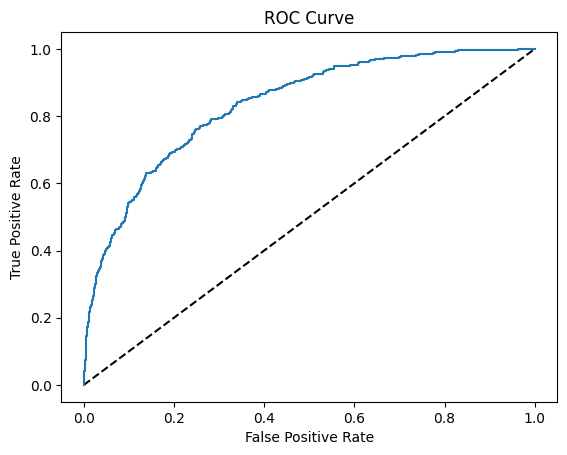

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [ ]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [ ]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [ ]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)